# ED LOS ANALYSIS

## load dataset + packages

In [2]:
import pandas as pd
import te2rules
import numpy as np
from te2rules.explainer import ModelExplainer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier


pd.set_option('display.max_columns', 100)  # 


In [3]:
df_master = pd.read_csv('df_master_imputed_iter_new.csv')

In [4]:
# ed_los_iter is the imputed outcome variable

# Calculate the mean of ed_los in hours
mean_ed_los_hours = df_master['ed_los_hours_iter'].mean()
std_ed_los_hours = df_master['ed_los_hours_iter'].std()

print(f'The mean of ED LOS in hours is: {mean_ed_los_hours}')
print(f'The std of ED LOS in hours is: {std_ed_los_hours}')

The mean of ED LOS in hours is: 6.402329931825367
The std of ED LOS in hours is: 4.284560545043614


In [5]:
#original ed los
# Convert the ed_los column to timedelta
df_master['ed_los'] = pd.to_timedelta(df_master['ed_los'])

# Convert the timedelta to hours
df_master['ed_los_hours'] = df_master['ed_los'].dt.total_seconds() / 3600

# Calculate the mean of ed_los in hours
mean_ed_los_hours = df_master['ed_los_hours'].mean()
std_ed_los_hours = df_master['ed_los_hours'].std()

print(f'The mean of ED LOS in hours is: {mean_ed_los_hours}')
print(f'The std of ED LOS in hours is: {std_ed_los_hours}')

The mean of ED LOS in hours is: 6.439400452445864
The std of ED LOS in hours is: 4.3320501376395075


In [6]:
#df_master['triage_acuity_iter'].unique()

In [7]:
# Round off all the decimal values in the 'triage_acuity' column
df_master['triage_acuity_iter'] = df_master['triage_acuity_iter'].round()

# Check the unique values in the 'triage_acuity' column after rounding off
unique_values_rounded = df_master['triage_acuity_iter'].unique()
print(unique_values_rounded)

[ 3.  2.  4.  1.  5. -0.]


## 4.5 hour Split

In [8]:
# Define the threshold for LOS classification
threshold = 4.5  # Define your threshold value here (in hours)

# Create a new binary variable indicating short or long stays
df_master['LOS_category'] = df_master['ed_los_hours_iter'].apply(lambda x: 'short' if x <= threshold else 'long')

# Optionally, encode the binary variable as 0s and 1s
df_master['LOS_category_encoded'] = df_master['LOS_category'].map({'short': 0, 'long': 1})

# Display the counts of each category
print(df_master['LOS_category'].value_counts())

LOS_category
long     252029
short    158898
Name: count, dtype: int64


In [9]:
df_train= df_master.sample(frac=0.8,random_state=10) #set seed
df_test= df_master.drop(df_train.index)

### Classification

In [63]:
df_master

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,anchor_age,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,...,race_BLACK/AFRICAN,race_BLACK/AFRICAN AMERICAN,race_BLACK/CAPE VERDEAN,race_BLACK/CARIBBEAN ISLAND,race_HISPANIC OR LATINO,race_HISPANIC/LATINO - CENTRAL AMERICAN,race_HISPANIC/LATINO - COLUMBIAN,race_HISPANIC/LATINO - CUBAN,race_HISPANIC/LATINO - DOMINICAN,race_HISPANIC/LATINO - GUATEMALAN,race_HISPANIC/LATINO - HONDURAN,race_HISPANIC/LATINO - MEXICAN,race_HISPANIC/LATINO - PUERTO RICAN,race_HISPANIC/LATINO - SALVADORAN,race_MULTIPLE RACE/ETHNICITY,race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,race_OTHER,race_PATIENT DECLINED TO ANSWER,race_PORTUGUESE,race_SOUTH AMERICAN,race_UNABLE TO OBTAIN,race_UNKNOWN,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,arrival_transport_AMBULANCE,arrival_transport_HELICOPTER,arrival_transport_OTHER,arrival_transport_UNKNOWN,arrival_transport_WALK IN,disposition_ADMITTED,disposition_ELOPED,disposition_EXPIRED,disposition_HOME,disposition_LEFT AGAINST MEDICAL ADVICE,disposition_LEFT WITHOUT BEING SEEN,disposition_OTHER,disposition_TRANSFER,insurance_Medicaid,insurance_Medicare,insurance_Other,disposition_encoded,arrival_transport_encoded,race_encoded,cci_score,eci_score,LOS_category,LOS_category_encoded
0,0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,Other,2180,52,False,0 days 04:13:00,NaN,NaN,False,True,False,0,0,0,2180-06-26 15:54:00,50 days 16:24:00,False,0,0,0,0,0,0,4.216667,NaN,50.68,36.888889,70.0,16.0,97.0,106.0,63.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,1,1,0,0,0,short,0
1,1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,Medicaid,2180,52,False,0 days 05:37:00,NaN,NaN,False,True,False,0,1,1,2180-07-22 16:24:00,25 days 18:53:00,False,0,1,1,0,0,0,5.616667,NaN,25.79,37.166667,88.0,18.0,97.0,116.0,88.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,1,1,0,5,5,long,1
2,3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,52,2180,2180-09-09,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,Medicaid,2180,52,False,0 days 13:30:00,2180-07-23 14:00:00,0 days 08:06:00,True,True,True,1,2,2,2180-07-23 05:54:00,0 days 00:00:00,True,1,2,2,0,0,0,13.500000,8.1,0.00,36.555556,87.0,14.0,97.0,71.0,43.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,0,1,0,5,8,long,1
3,4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,

In [64]:
#252033/410927

In [65]:
variable = ["age", "gender_encoded","cci_score","eci_score",
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d",
            
            "triage_temperature_iter", "triage_heartrate_iter", "triage_resprate_iter",
            "triage_o2sat_iter", "triage_sbp_iter", "triage_dbp_iter", "triage_pain_iter", 
            "triage_acuity_iter",
            
            #"ed_temperature_last_knn","ed_heartrate_last_knn","ed_resprate_last_knn","ed_o2sat_last_knn",
            #"ed_sbp_last_knn","ed_dbp_last_knn","ed_pain_last_knn",
            
    'race_AMERICAN INDIAN/ALASKA NATIVE','race_ASIAN','race_ASIAN - ASIAN INDIAN','race_ASIAN - CHINESE',
    'race_ASIAN - KOREAN','race_ASIAN - SOUTH EAST ASIAN','race_BLACK/AFRICAN','race_BLACK/AFRICAN AMERICAN',
    'race_BLACK/CAPE VERDEAN','race_BLACK/CARIBBEAN ISLAND',
    'race_HISPANIC OR LATINO','race_HISPANIC/LATINO - CENTRAL AMERICAN','race_HISPANIC/LATINO - COLUMBIAN',
    'race_HISPANIC/LATINO - CUBAN','race_HISPANIC/LATINO - DOMINICAN','race_HISPANIC/LATINO - GUATEMALAN',
    'race_HISPANIC/LATINO - HONDURAN','race_HISPANIC/LATINO - MEXICAN','race_HISPANIC/LATINO - PUERTO RICAN',
    'race_HISPANIC/LATINO - SALVADORAN','race_MULTIPLE RACE/ETHNICITY','race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
    'race_OTHER','race_PATIENT DECLINED TO ANSWER','race_PORTUGUESE',
    'race_SOUTH AMERICAN','race_UNABLE TO OBTAIN','race_UNKNOWN','race_WHITE','race_WHITE - BRAZILIAN',
    'race_WHITE - EASTERN EUROPEAN','race_WHITE - OTHER EUROPEAN','race_WHITE - RUSSIAN',
    'arrival_transport_AMBULANCE','arrival_transport_HELICOPTER','arrival_transport_OTHER','arrival_transport_UNKNOWN',
    'arrival_transport_WALK IN',
    'disposition_ADMITTED','disposition_ELOPED','disposition_EXPIRED',
    'disposition_HOME','disposition_LEFT AGAINST MEDICAL ADVICE','disposition_LEFT WITHOUT BEING SEEN','disposition_OTHER',
    'disposition_TRANSFER',


            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression",
            "med_event",'microbiology_event'
           ]

outcome = "LOS_category_encoded"

In [66]:
X_train = df_train[variable]
y_train = df_train[outcome]

X_test = df_test[variable]
y_test = df_test[outcome]

### Random Forest (ALL VARS)

In [67]:
#all variables
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

# Step 4: Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Step 5: Evaluate Classifier
y_pred = rf_classifier.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate AUC Score
auc_score = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])
print("AUC Score:", auc_score)

# Calculate Specificity and Sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)

# Calculate F1 Score
f1_score = classification_report(y_test, y_pred)
print("F1 Score:\n", f1_score)

Accuracy: 0.7125387844497171
AUC Score: 0.7486823784117952
Specificity: 0.48184568835098335
Sensitivity: 0.8576015220881147
F1 Score:
               precision    recall  f1-score   support

           0       0.68      0.48      0.56     31728
           1       0.72      0.86      0.79     50457

    accuracy                           0.71     82185
   macro avg       0.70      0.67      0.67     82185
weighted avg       0.71      0.71      0.70     82185



In [68]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': variable, 'Importance': feature_importances})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the top n most important features
n = 18  # Number of top features to display
importance_df

,Feature,Importance
0,age,0.083850
17,triage_sbp_iter,0.081646
14,triage_heartrate_iter,0.080770
18,triage_dbp_iter,0.079240
13,triage_temperature_iter,0.075929
...,...,...
34,race_HISPANIC/LATINO - CUBAN,0.000413
42,race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,0.000341
41,race_MULTIPLE RACE/ETHNICITY,0.000224
47,race_UNABLE TO OBTAIN,0.000149


### Gradient Boosting (ALL VARS)

In [69]:
from sklearn.ensemble import GradientBoostingClassifier

#Train Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)

#Evaluate Classifier
y_pred = gb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate AUC Score
auc_score = roc_auc_score(y_test, gb_classifier.predict_proba(X_test)[:, 1])
print("AUC Score:", auc_score)

# Calculate Specificity and Sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7100444119973232
Accuracy: 0.7100444119973232
AUC Score: 0.7443582158691345
Specificity: 0.4281391830559758
Sensitivity: 0.8873099867213667
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.43      0.53     31728
           1       0.71      0.89      0.79     50457

    accuracy                           0.71     82185
   macro avg       0.71      0.66      0.66     82185
weighted avg       0.71      0.71      0.69     82185

Confusion Matrix:
 [[13584 18144]
 [ 5686 44771]]


In [70]:
feature_importances = gb_classifier.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': variable, 'Importance': feature_importances})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the top n most important features
#n = 18  # Number of top features to display
importance_df

,Feature,Importance
20,triage_acuity_iter,0.341333
59,disposition_ADMITTED,0.099718
57,arrival_transport_UNKNOWN,0.083275
3,eci_score,0.079053
68,chiefcom_abdominal_pain,0.067900
...,...,...
39,race_HISPANIC/LATINO - PUERTO RICAN,0.000000
77,cci_MI,0.000000
78,cci_CHF,0.000000
79,cci_PVD,0.000000


In [71]:
# Extract the first 10 variable names
top_10_variables = importance_df.head(10)['Feature'].tolist()

# Display the first 10 variable names
print(top_10_variables)

['triage_acuity_iter', 'disposition_ADMITTED', 'arrival_transport_UNKNOWN', 'eci_score', 'chiefcom_abdominal_pain', 'arrival_transport_AMBULANCE', 'age', 'med_event', 'disposition_LEFT WITHOUT BEING SEEN', 'disposition_HOME']


### Gradeint Boosting (With CV)

In [72]:
# Import necessary libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd


# Define feature columns and target outcome
X = df_master[variable]  
y = df_master[outcome]   

# Define 5-fold Stratified Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store metrics for each fold
accuracy_list = []
auc_list = []
specificity_list = []
sensitivity_list = []
f1_list = []
feature_importances_list = []

# Loop over each fold
for train_index, test_index in skf.split(X, y):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Gradient Boosting Classifier
    gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb_classifier.fit(X_train, y_train)
    
    # Make predictions
    y_pred = gb_classifier.predict(X_test)
    y_pred_prob = gb_classifier.predict_proba(X_test)[:, 1]
    
    # Calculate metrics for the fold
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    f1 = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
    feature_importances = gb_classifier.feature_importances_
    
    # Store metrics
    accuracy_list.append(accuracy)
    auc_list.append(auc_score)
    specificity_list.append(specificity)
    sensitivity_list.append(sensitivity)
    f1_list.append(f1)
    feature_importances_list.append(feature_importances)

# Calculate average metrics across all folds
print("Average Metrics Across 5 Folds:")
print(f"Accuracy: {np.mean(accuracy_list):.4f} (+/- {np.std(accuracy_list):.4f})")
print(f"AUC Score: {np.mean(auc_list):.4f} (+/- {np.std(auc_list):.4f})")
print(f"Specificity: {np.mean(specificity_list):.4f} (+/- {np.std(specificity_list):.4f})")
print(f"Sensitivity: {np.mean(sensitivity_list):.4f} (+/- {np.std(sensitivity_list):.4f})")
print(f"F1 Score: {np.mean(f1_list):.4f} (+/- {np.std(f1_list):.4f})")


Average Metrics Across 5 Folds:
Accuracy: 0.7123 (+/- 0.0017)
AUC Score: 0.7471 (+/- 0.0014)
Specificity: 0.4386 (+/- 0.0044)
Sensitivity: 0.8848 (+/- 0.0018)
F1 Score: 0.6940 (+/- 0.0020)


In [73]:
# Calculate average feature importances
average_feature_importances = np.mean(feature_importances_list, axis=0)
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': average_feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances_df)

# Optional: Save to CSV for further analysis
# feature_importances_df.to_csv('feature_importances.csv', index=False)


Feature Importances:
                             Feature  Importance
20                triage_acuity_iter    0.335681
59              disposition_ADMITTED    0.097400
57         arrival_transport_UNKNOWN    0.083431
3                          eci_score    0.076012
68           chiefcom_abdominal_pain    0.068335
..                               ...         ...
77                            cci_MI    0.000000
78                           cci_CHF    0.000000
80                        cci_Stroke    0.000000
35  race_HISPANIC/LATINO - DOMINICAN    0.000000
30       race_BLACK/CARIBBEAN ISLAND    0.000000

[114 rows x 2 columns]


In [41]:
# Extract the first 10 variable names
top_10_variables = feature_importances_df.head(10)['Feature'].tolist()

# Display the first 10 variable names
print(top_10_variables)

['triage_acuity_iter', 'disposition_ADMITTED', 'arrival_transport_UNKNOWN', 'eci_score', 'chiefcom_abdominal_pain', 'arrival_transport_AMBULANCE', 'age', 'med_event', 'disposition_LEFT WITHOUT BEING SEEN', 'disposition_HOME']


### Repeat Experiment with top 10 vars and stratified 5 folds CV

In [10]:
variable = ['triage_acuity_iter', 'disposition_ADMITTED', 'arrival_transport_UNKNOWN', 
            'eci_score', 'chiefcom_abdominal_pain', 'arrival_transport_AMBULANCE',
            'age', 'med_event', 'disposition_LEFT WITHOUT BEING SEEN', 'disposition_HOME']


outcome = "LOS_category_encoded"

In [75]:
#
X_train = df_train[variable]
y_train = df_train[outcome]

X_test = df_test[variable]
y_test = df_test[outcome]

In [76]:
model_predictions = {}

In [89]:
model_predictions

{'RF': array([1, 1, 1, ..., 0, 0, 1]),
 'GB': array([1, 1, 1, ..., 0, 0, 0]),
 'LR': array([1, 1, 1, ..., 0, 0, 1]),
 'MLP': array([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])}

#### random forest

In [77]:

# Define feature columns and target outcome
X = df_master[variable]  
y = df_master[outcome]  

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score, f1_score

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize the Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the scores for each fold
train_accuracies = []
val_accuracies = []
train_aucs = []
val_aucs = []
train_sensitivities = []
val_sensitivities = []
train_specificities = []
val_specificities = []
train_f1_scores = []
val_f1_scores = []

# Perform 5-fold cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model
    rf_classifier.fit(X_train_fold, y_train_fold)
    
    # Predict on training and validation sets
    y_train_pred = rf_classifier.predict(X_train_fold)
    y_val_pred = rf_classifier.predict(X_val_fold)
    
    # Calculate metrics for training set
    train_accuracies.append(accuracy_score(y_train_fold, y_train_pred))
    train_aucs.append(roc_auc_score(y_train_fold, rf_classifier.predict_proba(X_train_fold)[:, 1]))
    train_sensitivities.append(recall_score(y_train_fold, y_train_pred))
    tn, fp, fn, tp = confusion_matrix(y_train_fold, y_train_pred).ravel()
    train_specificities.append(tn / (tn + fp))
    train_f1_scores.append(f1_score(y_train_fold, y_train_pred))
    
    # Calculate metrics for validation set
    val_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
    val_aucs.append(roc_auc_score(y_val_fold, rf_classifier.predict_proba(X_val_fold)[:, 1]))
    val_sensitivities.append(recall_score(y_val_fold, y_val_pred))
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_pred).ravel()
    val_specificities.append(tn / (tn + fp))
    val_f1_scores.append(f1_score(y_val_fold, y_val_pred))

# Train the model on the full training set
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_test_pred = rf_classifier.predict(X_test)
y_test_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Calculate metrics on the test set
final_test_accuracy = accuracy_score(y_test, y_test_pred)
final_test_auc = roc_auc_score(y_test, y_test_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
final_test_specificity = tn / (tn + fp)
final_test_sensitivity = tp / (tp + fn)
final_test_f1 = f1_score(y_test, y_test_pred)
#save model predictions

model_predictions['RF'] = y_test_pred

# Print mean scores with standard deviation (error) from cross-validation
print("Mean Train Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(train_accuracies), np.std(train_accuracies)))
print("Mean Validation Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(val_accuracies), np.std(val_accuracies)))
print("Mean Train AUC: {:.4f} (+/- {:.4f})".format(np.mean(train_aucs), np.std(train_aucs)))
print("Mean Validation AUC: {:.4f} (+/- {:.4f})".format(np.mean(val_aucs), np.std(val_aucs)))
print("Mean Train Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(train_sensitivities), np.std(train_sensitivities)))
print("Mean Validation Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(val_sensitivities), np.std(val_sensitivities)))
print("Mean Train Specificity: {:.4f} (+/- {:.4f})".format(np.mean(train_specificities), np.std(train_specificities)))
print("Mean Validation Specificity: {:.4f} (+/- {:.4f})".format(np.mean(val_specificities), np.std(val_specificities)))
print("Mean Train F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(train_f1_scores), np.std(train_f1_scores)))
print("Mean Validation F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(val_f1_scores), np.std(val_f1_scores)))

# Print final test set results
print("\nTest Set Evaluation:")
print(f"Accuracy: {final_test_accuracy:.4f}")
print(f"AUC Score: {final_test_auc:.4f}")
print(f"Specificity: {final_test_specificity:.4f}")
print(f"Sensitivity: {final_test_sensitivity:.4f}")
print(f"F1 Score: {final_test_f1:.4f}")


Mean Train Accuracy: 0.7329 (+/- 0.0003)
Mean Validation Accuracy: 0.6799 (+/- 0.0017)
Mean Train AUC: 0.8048 (+/- 0.0004)
Mean Validation AUC: 0.7010 (+/- 0.0016)
Mean Train Sensitivity: 0.8367 (+/- 0.0019)
Mean Validation Sensitivity: 0.7926 (+/- 0.0018)
Mean Train Specificity: 0.5682 (+/- 0.0028)
Mean Validation Specificity: 0.5011 (+/- 0.0066)
Mean Train F1 Score: 0.7935 (+/- 0.0005)
Mean Validation F1 Score: 0.7523 (+/- 0.0008)

Test Set Evaluation:
Accuracy: 0.6825
AUC Score: 0.7049
Specificity: 0.4977
Sensitivity: 0.7991
F1 Score: 0.7553


#### gradeint boosting

In [79]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Initialize the Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the scores for each fold
train_accuracies = []
val_accuracies = []
train_aucs = []
val_aucs = []
train_sensitivities = []
val_sensitivities = []
train_specificities = []
val_specificities = []
train_f1_scores = []
val_f1_scores = []

# Perform 5-fold cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model
    gb_classifier.fit(X_train_fold, y_train_fold)
    
    # Predict on training and validation sets
    y_train_pred = gb_classifier.predict(X_train_fold)
    y_val_pred = gb_classifier.predict(X_val_fold)
    
    # Calculate metrics for training set
    train_accuracies.append(accuracy_score(y_train_fold, y_train_pred))
    train_aucs.append(roc_auc_score(y_train_fold, gb_classifier.predict_proba(X_train_fold)[:, 1]))
    train_sensitivities.append(recall_score(y_train_fold, y_train_pred))
    tn, fp, fn, tp = confusion_matrix(y_train_fold, y_train_pred).ravel()
    train_specificities.append(tn / (tn + fp))
    train_f1_scores.append(f1_score(y_train_fold, y_train_pred))
    
    # Calculate metrics for validation set
    val_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
    val_aucs.append(roc_auc_score(y_val_fold, gb_classifier.predict_proba(X_val_fold)[:, 1]))
    val_sensitivities.append(recall_score(y_val_fold, y_val_pred))
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_pred).ravel()
    val_specificities.append(tn / (tn + fp))
    val_f1_scores.append(f1_score(y_val_fold, y_val_pred))

# Train the model on the full training set
gb_classifier.fit(X_train, y_train)

# Predict on the test set
y_test_pred = gb_classifier.predict(X_test)
y_test_pred_prob = gb_classifier.predict_proba(X_test)[:, 1]

# Calculate metrics on the test set
final_test_accuracy = accuracy_score(y_test, y_test_pred)
final_test_auc = roc_auc_score(y_test, y_test_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
final_test_specificity = tn / (tn + fp)
final_test_sensitivity = tp / (tp + fn)
final_test_f1 = f1_score(y_test, y_test_pred)

#save model predictions

model_predictions['GB'] = y_test_pred

# Print mean scores with standard deviation (error) from cross-validation
print("Mean Train Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(train_accuracies), np.std(train_accuracies)))
print("Mean Validation Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(val_accuracies), np.std(val_accuracies)))
print("Mean Train AUC: {:.4f} (+/- {:.4f})".format(np.mean(train_aucs), np.std(train_aucs)))
print("Mean Validation AUC: {:.4f} (+/- {:.4f})".format(np.mean(val_aucs), np.std(val_aucs)))
print("Mean Train Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(train_sensitivities), np.std(train_sensitivities)))
print("Mean Validation Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(val_sensitivities), np.std(val_sensitivities)))
print("Mean Train Specificity: {:.4f} (+/- {:.4f})".format(np.mean(train_specificities), np.std(train_specificities)))
print("Mean Validation Specificity: {:.4f} (+/- {:.4f})".format(np.mean(val_specificities), np.std(val_specificities)))
print("Mean Train F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(train_f1_scores), np.std(train_f1_scores)))
print("Mean Validation F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(val_f1_scores), np.std(val_f1_scores)))

# Print final test set results
print("\nTest Set Evaluation:")
print(f"Accuracy: {final_test_accuracy:.4f}")
print(f"AUC Score: {final_test_auc:.4f}")
print(f"Specificity: {final_test_specificity:.4f}")
print(f"Sensitivity: {final_test_sensitivity:.4f}")
print(f"F1 Score: {final_test_f1:.4f}")


Mean Train Accuracy: 0.6998 (+/- 0.0006)
Mean Validation Accuracy: 0.6993 (+/- 0.0012)
Mean Train AUC: 0.7309 (+/- 0.0007)
Mean Validation AUC: 0.7302 (+/- 0.0015)
Mean Train Sensitivity: 0.8824 (+/- 0.0045)
Mean Validation Sensitivity: 0.8820 (+/- 0.0045)
Mean Train Specificity: 0.4101 (+/- 0.0086)
Mean Validation Specificity: 0.4095 (+/- 0.0076)
Mean Train F1 Score: 0.7829 (+/- 0.0006)
Mean Validation F1 Score: 0.7825 (+/- 0.0011)

Test Set Evaluation:
Accuracy: 0.6993
AUC Score: 0.7313
Specificity: 0.3997
Sensitivity: 0.8882
F1 Score: 0.7837


#### logistic regression

In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Logistic Regression classifier
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)

# Initialize the Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the scores for each fold
train_accuracies = []
val_accuracies = []
train_aucs = []
val_aucs = []
train_sensitivities = []
val_sensitivities = []
train_specificities = []
val_specificities = []
train_f1_scores = []
val_f1_scores = []

# Perform 5-fold cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model
    lr_classifier.fit(X_train_fold, y_train_fold)
    
    # Predict on training and validation sets
    y_train_pred = lr_classifier.predict(X_train_fold)
    y_val_pred = lr_classifier.predict(X_val_fold)
    
    # Calculate metrics for training set
    train_accuracies.append(accuracy_score(y_train_fold, y_train_pred))
    train_aucs.append(roc_auc_score(y_train_fold, lr_classifier.predict_proba(X_train_fold)[:, 1]))
    train_sensitivities.append(recall_score(y_train_fold, y_train_pred))
    tn, fp, fn, tp = confusion_matrix(y_train_fold, y_train_pred).ravel()
    train_specificities.append(tn / (tn + fp))
    train_f1_scores.append(f1_score(y_train_fold, y_train_pred))
    
    # Calculate metrics for validation set
    val_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
    val_aucs.append(roc_auc_score(y_val_fold, lr_classifier.predict_proba(X_val_fold)[:, 1]))
    val_sensitivities.append(recall_score(y_val_fold, y_val_pred))
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_pred).ravel()
    val_specificities.append(tn / (tn + fp))
    val_f1_scores.append(f1_score(y_val_fold, y_val_pred))

# Train the model on the full training set
lr_classifier.fit(X_train, y_train)

# Predict on the test set
y_test_pred = lr_classifier.predict(X_test)
y_test_pred_prob = lr_classifier.predict_proba(X_test)[:, 1]

# Calculate metrics on the test set
final_test_accuracy = accuracy_score(y_test, y_test_pred)
final_test_auc = roc_auc_score(y_test, y_test_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
final_test_specificity = tn / (tn + fp)
final_test_sensitivity = tp / (tp + fn)
final_test_f1 = f1_score(y_test, y_test_pred)
#save model predictions

model_predictions['LR'] = y_test_pred

# Print mean scores with standard deviation (error) from cross-validation
print("Mean Train Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(train_accuracies), np.std(train_accuracies)))
print("Mean Validation Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(val_accuracies), np.std(val_accuracies)))
print("Mean Train AUC: {:.4f} (+/- {:.4f})".format(np.mean(train_aucs), np.std(train_aucs)))
print("Mean Validation AUC: {:.4f} (+/- {:.4f})".format(np.mean(val_aucs), np.std(val_aucs)))
print("Mean Train Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(train_sensitivities), np.std(train_sensitivities)))
print("Mean Validation Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(val_sensitivities), np.std(val_sensitivities)))
print("Mean Train Specificity: {:.4f} (+/- {:.4f})".format(np.mean(train_specificities), np.std(train_specificities)))
print("Mean Validation Specificity: {:.4f} (+/- {:.4f})".format(np.mean(val_specificities), np.std(val_specificities)))
print("Mean Train F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(train_f1_scores), np.std(train_f1_scores)))
print("Mean Validation F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(val_f1_scores), np.std(val_f1_scores)))

# Print final test set results
print("\nTest Set Evaluation:")
print(f"Accuracy: {final_test_accuracy:.4f}")
print(f"AUC Score: {final_test_auc:.4f}")
print(f"Specificity: {final_test_specificity:.4f}")
print(f"Sensitivity: {final_test_sensitivity:.4f}")
print(f"F1 Score: {final_test_f1:.4f}")


Mean Train Accuracy: 0.6930 (+/- 0.0002)
Mean Validation Accuracy: 0.6929 (+/- 0.0008)
Mean Train AUC: 0.6994 (+/- 0.0002)
Mean Validation AUC: 0.6994 (+/- 0.0013)
Mean Train Sensitivity: 0.8581 (+/- 0.0008)
Mean Validation Sensitivity: 0.8581 (+/- 0.0009)
Mean Train Specificity: 0.4312 (+/- 0.0013)
Mean Validation Specificity: 0.4310 (+/- 0.0031)
Mean Train F1 Score: 0.7742 (+/- 0.0002)
Mean Validation F1 Score: 0.7742 (+/- 0.0004)

Test Set Evaluation:
Accuracy: 0.6939
AUC Score: 0.6990
Specificity: 0.4346
Sensitivity: 0.8573
F1 Score: 0.7745


#### SVM

In [53]:
#TAKES VERY LONG TIME
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score, f1_score
from sklearn.svm import SVC
import numpy as np

# Initialize the SVM classifier
svm_classifier = SVC(probability=True, random_state=42)

# Initialize the Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the scores for each fold
train_accuracies = []
val_accuracies = []
train_aucs = []
val_aucs = []
train_sensitivities = []
val_sensitivities = []
train_specificities = []
val_specificities = []
train_f1_scores = []
val_f1_scores = []

# Perform 5-fold cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model
    svm_classifier.fit(X_train_fold, y_train_fold)
    
    # Predict on training and validation sets
    y_train_pred = svm_classifier.predict(X_train_fold)
    y_val_pred = svm_classifier.predict(X_val_fold)
    
    # Calculate metrics for training set
    train_accuracies.append(accuracy_score(y_train_fold, y_train_pred))
    train_aucs.append(roc_auc_score(y_train_fold, svm_classifier.predict_proba(X_train_fold)[:, 1]))
    train_sensitivities.append(recall_score(y_train_fold, y_train_pred))
    tn, fp, fn, tp = confusion_matrix(y_train_fold, y_train_pred).ravel()
    train_specificities.append(tn / (tn + fp))
    train_f1_scores.append(f1_score(y_train_fold, y_train_pred))
    
    # Calculate metrics for validation set
    val_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
    val_aucs.append(roc_auc_score(y_val_fold, svm_classifier.predict_proba(X_val_fold)[:, 1]))
    val_sensitivities.append(recall_score(y_val_fold, y_val_pred))
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_pred).ravel()
    val_specificities.append(tn / (tn + fp))
    val_f1_scores.append(f1_score(y_val_fold, y_val_pred))

# Train the model on the full training set
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_test_pred = svm_classifier.predict(X_test)
y_test_pred_prob = svm_classifier.predict_proba(X_test)[:, 1]

# Calculate metrics on the test set
final_test_accuracy = accuracy_score(y_test, y_test_pred)
final_test_auc = roc_auc_score(y_test, y_test_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
final_test_specificity = tn / (tn + fp)
final_test_sensitivity = tp / (tp + fn)
final_test_f1 = f1_score(y_test, y_test_pred)

# Print mean scores with standard deviation (error) from cross-validation
print("Mean Train Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(train_accuracies), np.std(train_accuracies)))
print("Mean Validation Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(val_accuracies), np.std(val_accuracies)))
print("Mean Train AUC: {:.4f} (+/- {:.4f})".format(np.mean(train_aucs), np.std(train_aucs)))
print("Mean Validation AUC: {:.4f} (+/- {:.4f})".format(np.mean(val_aucs), np.std(val_aucs)))
print("Mean Train Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(train_sensitivities), np.std(train_sensitivities)))
print("Mean Validation Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(val_sensitivities), np.std(val_sensitivities)))
print("Mean Train Specificity: {:.4f} (+/- {:.4f})".format(np.mean(train_specificities), np.std(train_specificities)))
print("Mean Validation Specificity: {:.4f} (+/- {:.4f})".format(np.mean(val_specificities), np.std(val_specificities)))
print("Mean Train F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(train_f1_scores), np.std(train_f1_scores)))
print("Mean Validation F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(val_f1_scores), np.std(val_f1_scores)))

# Print final test set results
print("\nTest Set Evaluation:")
print(f"Accuracy: {final_test_accuracy:.4f}")
print(f"AUC Score: {final_test_auc:.4f}")
print(f"Specificity: {final_test_specificity:.4f}")
print(f"Sensitivity: {final_test_sensitivity:.4f}")
print(f"F1 Score: {final_test_f1:.4f}")


Mean Train Accuracy: 0.6810 (+/- 0.0004)
Mean Validation Accuracy: 0.6810 (+/- 0.0012)
Mean Train AUC: 0.6852 (+/- 0.0006)
Mean Validation AUC: 0.6851 (+/- 0.0019)
Mean Train Sensitivity: 0.8948 (+/- 0.0003)
Mean Validation Sensitivity: 0.8948 (+/- 0.0018)
Mean Train Specificity: 0.3420 (+/- 0.0010)
Mean Validation Specificity: 0.3421 (+/- 0.0020)
Mean Train F1 Score: 0.7747 (+/- 0.0002)
Mean Validation F1 Score: 0.7748 (+/- 0.0010)

Test Set Evaluation:
Accuracy: 0.6807
AUC Score: 0.6834
Specificity: 0.3393
Sensitivity: 0.8954
F1 Score: 0.7749


#### MLP

In [81]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, f1_score, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
import numpy as np

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the scores for each fold
train_aucs = []
val_aucs = []
train_sensitivities = []
val_sensitivities = []
train_specificities = []
val_specificities = []
train_f1_scores = []
val_f1_scores = []
train_accuracies = []
val_accuracies = []

# Define MLP model architecture
def create_mlp():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['AUC'])
    return model

# Perform 5-fold cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize the MLP model
    mlp_model = create_mlp()

    # Train the model
    mlp_model.fit(X_train_fold, y_train_fold, batch_size=200, epochs=20, verbose=0)

    # Predict on training and validation sets
    y_train_pred_prob = mlp_model.predict(X_train_fold)
    y_train_pred = (y_train_pred_prob > 0.5).astype(int)
    y_val_pred_prob = mlp_model.predict(X_val_fold)
    y_val_pred = (y_val_pred_prob > 0.5).astype(int)

    # Calculate metrics for training set
    train_accuracies.append(accuracy_score(y_train_fold, y_train_pred))
    train_aucs.append(roc_auc_score(y_train_fold, y_train_pred_prob))
    train_sensitivities.append(recall_score(y_train_fold, y_train_pred))
    tn, fp, fn, tp = confusion_matrix(y_train_fold, y_train_pred).ravel()
    train_specificities.append(tn / (tn + fp))
    train_f1_scores.append(f1_score(y_train_fold, y_train_pred))

    # Calculate metrics for validation set
    val_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
    val_aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob))
    val_sensitivities.append(recall_score(y_val_fold, y_val_pred))
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_pred).ravel()
    val_specificities.append(tn / (tn + fp))
    val_f1_scores.append(f1_score(y_val_fold, y_val_pred))

# Train the model on the full training set
mlp_model = create_mlp()
mlp_model.fit(X_train, y_train, batch_size=200, epochs=20, verbose=0)

# Predict on the test set
y_test_pred_prob = mlp_model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Calculate metrics on the test set
final_test_accuracy = accuracy_score(y_test, y_test_pred)
final_test_auc = roc_auc_score(y_test, y_test_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
final_test_specificity = tn / (tn + fp)
final_test_sensitivity = tp / (tp + fn)
final_test_f1 = f1_score(y_test, y_test_pred)

#save model predictions

model_predictions['MLP'] = y_test_pred

# Print mean scores with standard deviation (error) from cross-validation
print("Mean Train AUC: {:.4f} (+/- {:.4f})".format(np.mean(train_aucs), np.std(train_aucs)))
print("Mean Validation AUC: {:.4f} (+/- {:.4f})".format(np.mean(val_aucs), np.std(val_aucs)))
print("Mean Train Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(train_accuracies), np.std(train_accuracies)))
print("Mean Validation Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(val_accuracies), np.std(val_accuracies)))
print("Mean Train Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(train_sensitivities), np.std(train_sensitivities)))
print("Mean Validation Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(val_sensitivities), np.std(val_sensitivities)))
print("Mean Train Specificity: {:.4f} (+/- {:.4f})".format(np.mean(train_specificities), np.std(train_specificities)))
print("Mean Validation Specificity: {:.4f} (+/- {:.4f})".format(np.mean(val_specificities), np.std(val_specificities)))
print("Mean Train F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(train_f1_scores), np.std(train_f1_scores)))
print("Mean Validation F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(val_f1_scores), np.std(val_f1_scores)))

# Print final test set results
print("\nTest Set Evaluation:")
print(f"AUC Score: {final_test_auc:.4f}")
print(f"Accuracy: {final_test_accuracy:.4f}")
print(f"Specificity: {final_test_specificity:.4f}")
print(f"Sensitivity: {final_test_sensitivity:.4f}")
print(f"F1 Score: {final_test_f1:.4f}")


8219/8219 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 254us/step
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 2s 250us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 251us/step
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 2s 257us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 286us/step
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 2s 249us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 262us/step
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 2s 254us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 255us/step
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 1s 251us/step
Mean Train AUC: 0.7299 (+/- 0.0011)
Mean Validation AUC: 0.7297 (+/- 0.0021)
Mean Train Accuracy: 0.6975 (+/- 0.0017)
Mean Validation Accuracy: 0.6971 (+/- 0.0025)
Mean Train Sensitivity: 0.8359 (+/- 0.0292)
Mean Validation Sensitivity: 0.8351 (+/- 0.0288)
Mean Train Specificity: 0.4780 (+/- 0.0424)
Mean Validation Specificity: 0.4782 (+/- 0.0396)
Mean Train F1 Score: 0.7720 (+/- 0.0071)
Mean Validation F1 Score: 0.7716 (+/- 0.0075)

Test Set Evaluation:
AUC Score: 0.7309
Accuracy: 0.6998
Specificity

### Mcnemar Test to Compare (Imbalanced dataset)

McNemar's test is used for comparing the classification performance of two models to determine if the observed differences are statistically significant, we compare across models used

In [82]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [83]:
# Flatten the MLP predictions and update the dictionary
model_predictions['MLP'] = model_predictions['MLP'].flatten()

In [84]:
model_predictions

{'RF': array([1, 0, 1, ..., 0, 1, 1]),
 'GB': array([1, 0, 1, ..., 0, 1, 1]),
 'LR': array([1, 0, 0, ..., 0, 1, 0]),
 'MLP': array([1, 0, 1, ..., 0, 1, 1])}

In [13]:
#model_pairs

In [86]:
import itertools
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar




# Perform pairwise McNemar's test for all model combinations
model_pairs = list(itertools.combinations(model_predictions.keys(), 2))

for model_a_name, model_b_name in model_pairs:
    # Predictions for the selected models
    model_a_predictions = model_predictions[model_a_name]
    model_b_predictions = model_predictions[model_b_name]

    # Construct contingency table
    both_correct = np.sum((model_a_predictions == y_test) & (model_b_predictions == y_test))
    model_a_correct_b_wrong = np.sum((model_a_predictions == y_test) & (model_b_predictions != y_test))
    model_b_correct_a_wrong = np.sum((model_b_predictions == y_test) & (model_a_predictions != y_test))
    both_wrong = np.sum((model_a_predictions != y_test) & (model_b_predictions != y_test))

    # Construct contingency table for McNemar's test
    contingency_table = [[both_correct, model_a_correct_b_wrong],
                         [model_b_correct_a_wrong, both_wrong]]

    # Apply McNemar's test
    result = mcnemar(contingency_table, exact=True)

    # Output results
    print(f"Comparison between {model_a_name} and {model_b_name}:")
    print(f"Chi-squared statistic: {result.statistic}")
    print(f"p-value: {result.pvalue}")

    if result.pvalue < 0.05:
        print(f"The difference between {model_a_name} and {model_b_name} is statistically significant.\n")
    else:
        print(f"The difference between {model_a_name} and {model_b_name} is not statistically significant.\n")


Comparison between RF and GB:
Chi-squared statistic: 4101.0
p-value: 3.6697148431845475e-45
The difference between RF and GB is statistically significant.

Comparison between RF and LR:
Chi-squared statistic: 5147.0
p-value: 1.5938230236417899e-18
The difference between RF and LR is statistically significant.

Comparison between RF and MLP:
Chi-squared statistic: 3850.0
p-value: 6.947795419467272e-50
The difference between RF and MLP is statistically significant.

Comparison between GB and LR:
Chi-squared statistic: 1812.0
p-value: 2.351898580546245e-12
The difference between GB and LR is statistically significant.

Comparison between GB and MLP:
Chi-squared statistic: 1370.0
p-value: 0.49452048057625353
The difference between GB and MLP is not statistically significant.

Comparison between LR and MLP:
Chi-squared statistic: 2559.0
p-value: 9.805126715938419e-11
The difference between LR and MLP is statistically significant.



 this means that GB and MLP performed similarly on the dataset, and there is no statistically significant advantage of one over the other in terms of predictive accuracy when evaluated using McNemar's test.

### Sampling techniques

In [89]:
import warnings
warnings.filterwarnings("ignore")


In [90]:
# Define feature columns and target outcome
X = df_master[variable]  
y = df_master[outcome]  

2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 285us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 250us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 251us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 261us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 251us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 261us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 260us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 259us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 260us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 240us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step
2055/2055 

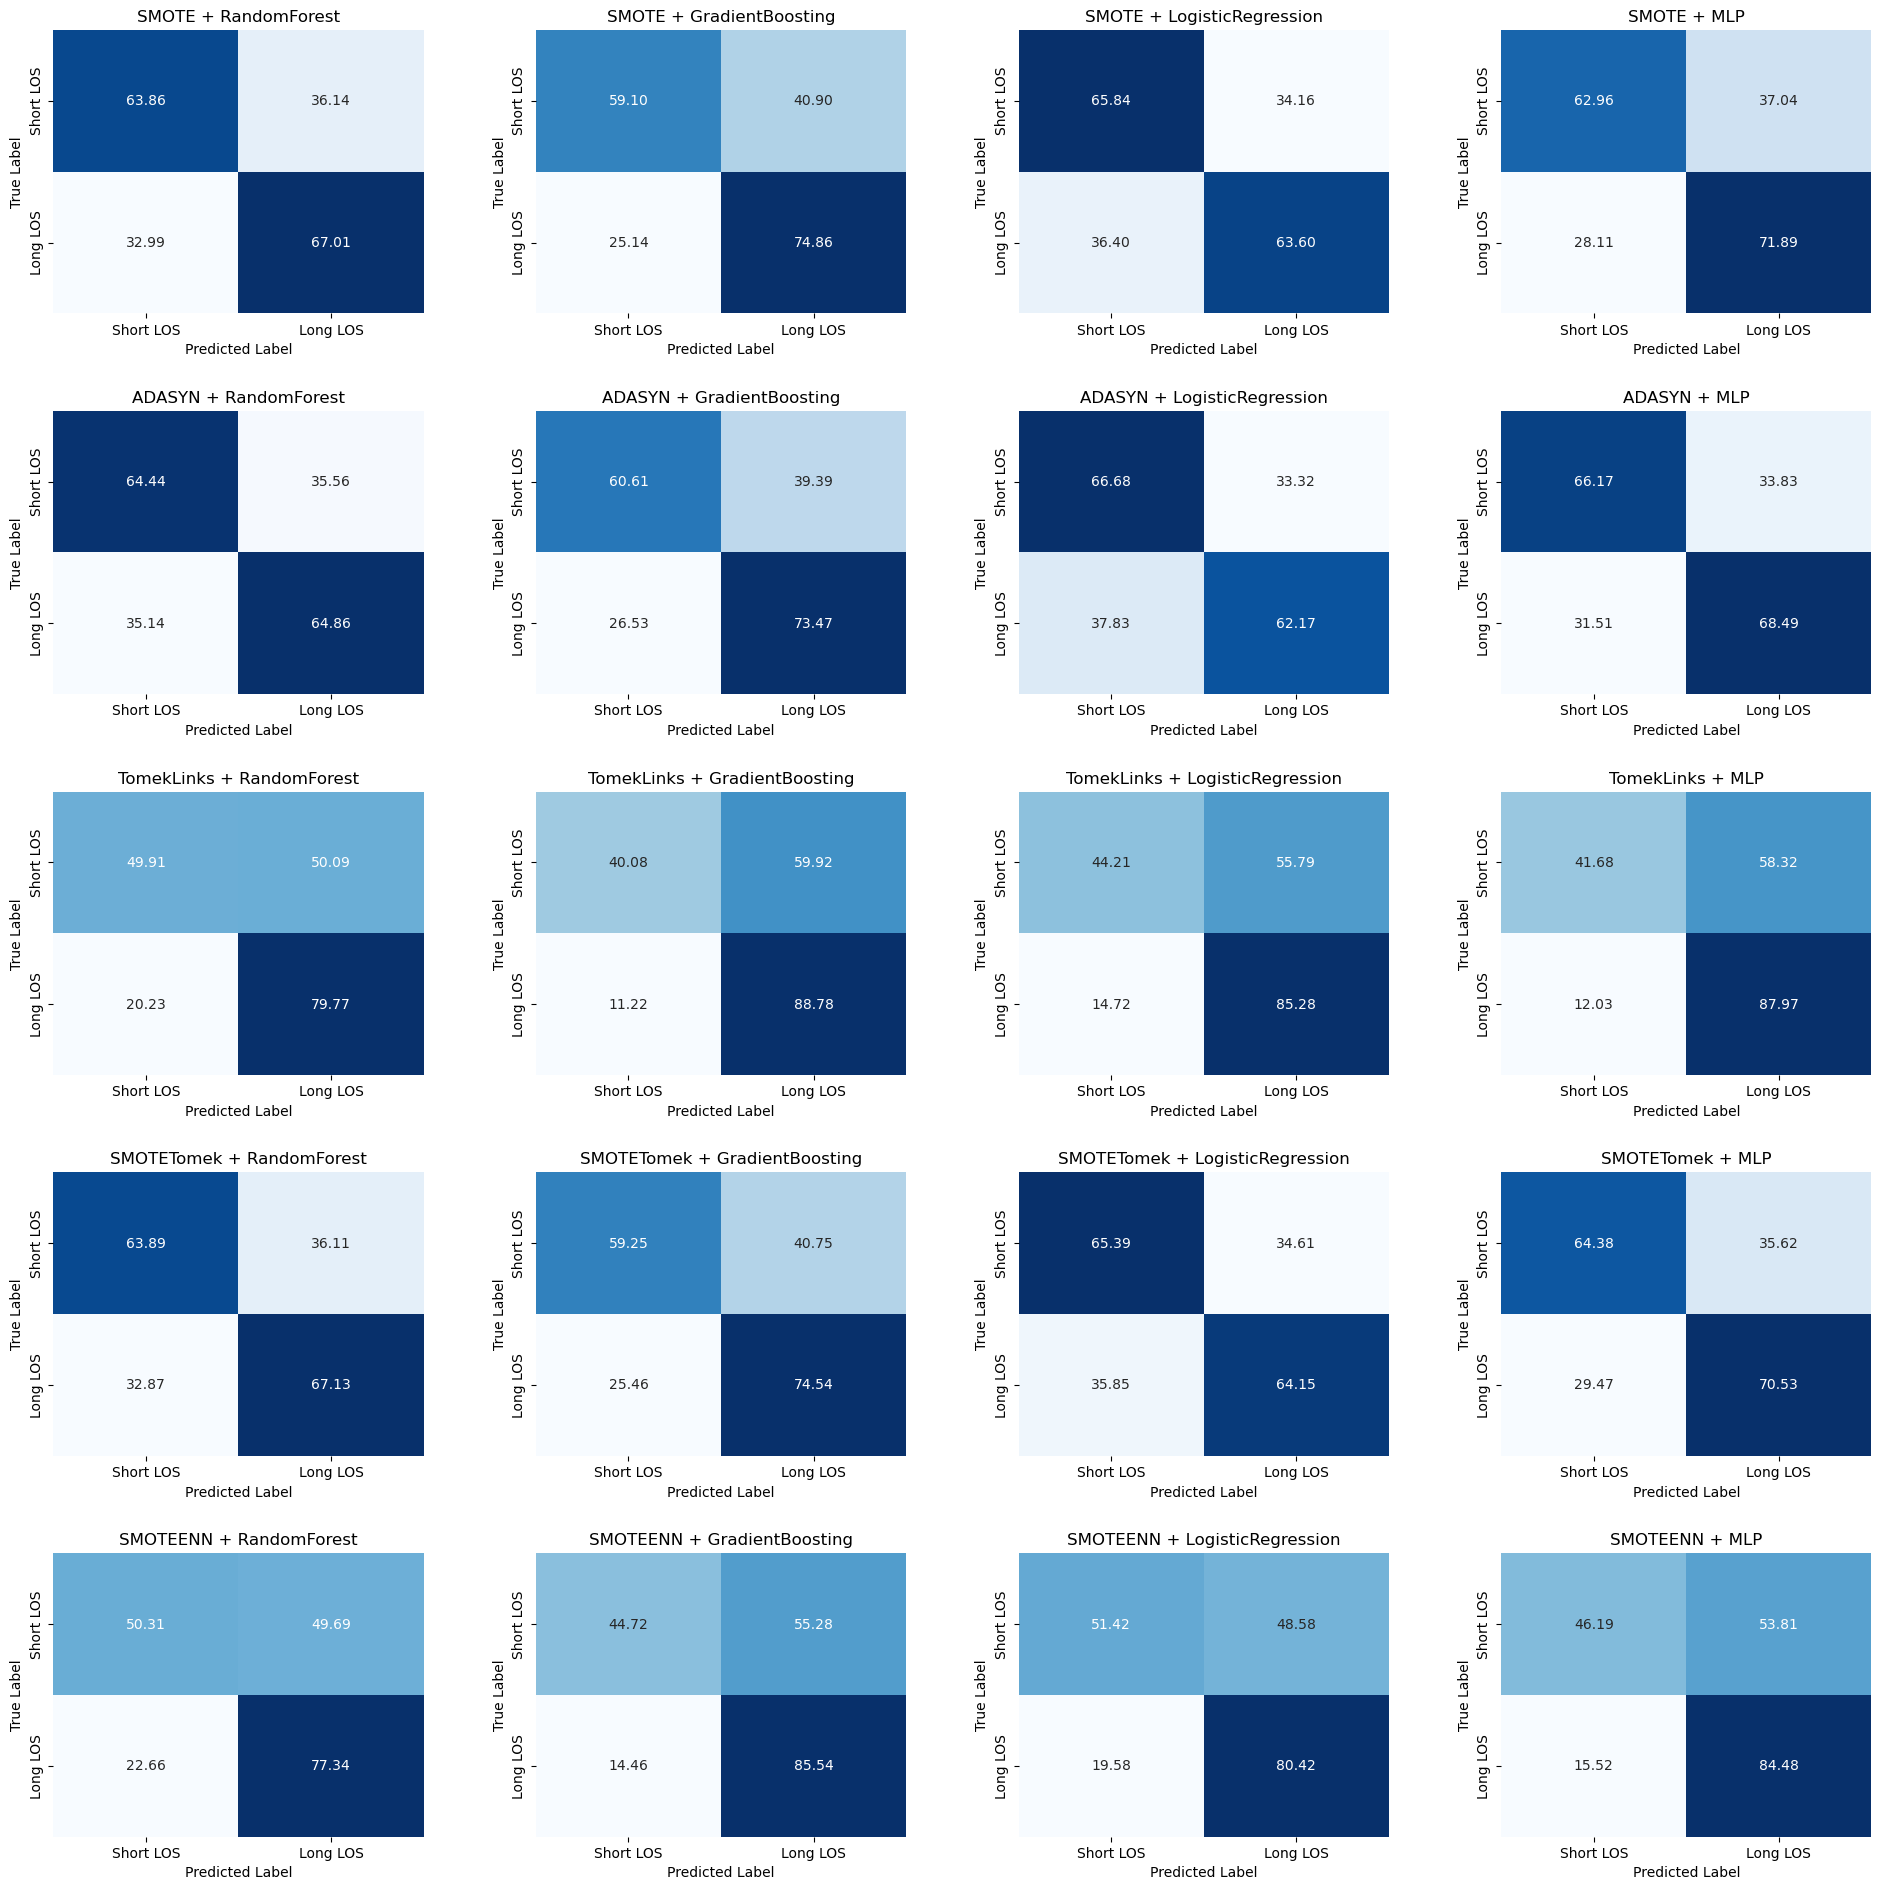

In [91]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
# df = pd.read_csv('your_dataset.csv')
# X = df.drop(columns=['target'])
# y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize sampling techniques
sampling_techniques = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'TomekLinks': TomekLinks(),
    'SMOTETomek': SMOTETomek(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)
}

# Function to create the MLP model
def create_mlp():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['AUC'])
    return model

# Initialize the classifiers
classifiers = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'MLP': create_mlp()  # Include MLP
}

# Define 5-fold Stratified Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop over each sampling technique
for technique_name, sampler in sampling_techniques.items():
    for classifier_name, classifier in classifiers.items():
        # Store metrics for each fold
        accuracy_list = []
        auc_list = []
        specificity_list = []
        sensitivity_list = []
        f1_list = []

        # Perform 5-fold cross-validation
        for train_index, val_index in skf.split(X_train, y_train):
            # Split the data into training and validation sets
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            # Apply the sampling technique to the training set
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_fold, y_train_fold)

            # Train the model
            if classifier_name == 'MLP':
                classifier.fit(X_train_resampled, y_train_resampled, batch_size=200, epochs=20, verbose=0)
            else:
                classifier.fit(X_train_resampled, y_train_resampled)

            # Predict on the validation set
            y_val_pred = (classifier.predict(X_val_fold) > 0.5).astype(int) if classifier_name == 'MLP' else classifier.predict(X_val_fold)
            y_val_pred_prob = classifier.predict_proba(X_val_fold)[:, 1] if classifier_name != 'MLP' else classifier.predict(X_val_fold)

            # Calculate metrics for the fold
            accuracy = accuracy_score(y_val_fold, y_val_pred)
            auc_score = roc_auc_score(y_val_fold, y_val_pred_prob)
            tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_pred).ravel()
            specificity = tn / (tn + fp)
            sensitivity = tp / (tp + fn)
            f1 = f1_score(y_val_fold, y_val_pred)

            # Store metrics
            accuracy_list.append(accuracy)
            auc_list.append(auc_score)
            specificity_list.append(specificity)
            sensitivity_list.append(sensitivity)
            f1_list.append(f1)

        # Calculate average metrics across all folds
        results[f"{technique_name}_{classifier_name}"] = {
            'Accuracy': (np.mean(accuracy_list), np.std(accuracy_list)),
            'AUC': (np.mean(auc_list), np.std(auc_list)),
            'Specificity': (np.mean(specificity_list), np.std(specificity_list)),
            'Sensitivity': (np.mean(sensitivity_list), np.std(sensitivity_list)),
            'F1 Score': (np.mean(f1_list), np.std(f1_list))
        }

# Set up subplots for confusion matrices
fig, axes = plt.subplots(len(sampling_techniques), len(classifiers), figsize=(20, 20))
fig.tight_layout(pad=5.0)

# Evaluate on the test set using each sampling technique and classifier
for i, (technique_name, sampler) in enumerate(sampling_techniques.items()):
    for j, (classifier_name, classifier) in enumerate(classifiers.items()):
        # Apply the sampling technique to the entire training set
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

        # Train the model on the resampled training set
        if classifier_name == 'MLP':
            classifier.fit(X_train_resampled, y_train_resampled, batch_size=200, epochs=20, verbose=0)
        else:
            classifier.fit(X_train_resampled, y_train_resampled)

        # Predict on the test set
        y_test_pred = (classifier.predict(X_test) > 0.5).astype(int) if classifier_name == 'MLP' else classifier.predict(X_test)

        # Confusion matrix for final test set in percentage form
        cm = confusion_matrix(y_test, y_test_pred)
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        # Plot confusion matrix
        ax = axes[i, j]
        sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar=False, ax=ax,
                    xticklabels=['Short LOS', 'Long LOS'], yticklabels=['Short LOS', 'Long LOS'])
        ax.set_title(f'{technique_name} + {classifier_name}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

# Adjust the layout and save the plot
plt.subplots_adjust(top=0.95)
plt.savefig('confusion_matrices_percentage_all_new.png')
plt.show()

In [92]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks, NearMiss
from imblearn.combine import SMOTETomek, SMOTEENN
import numpy as np
import pandas as pd

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize sampling techniques
sampling_techniques = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'TomekLinks': TomekLinks(),
    'NearMiss': NearMiss(version=1),
    'SMOTETomek': SMOTETomek(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)
}

# Function to create the MLP model
def create_mlp():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['AUC'])
    return model

# Initialize the classifiers
classifiers = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'MLP': create_mlp()  # Include MLP
}

# Define 5-fold Stratified Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dictionary to store results for each technique
results = {}

# Loop over each sampling technique
for technique_name, sampler in sampling_techniques.items():
    for classifier_name, classifier in classifiers.items():
        # Store metrics for each fold
        accuracy_list = []
        auc_list = []
        specificity_list = []
        sensitivity_list = []
        f1_list = []

        # Perform 5-fold cross-validation
        for train_index, val_index in skf.split(X_train, y_train):
            # Split the data into training and validation sets
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            # Apply the sampling technique to the training set
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_fold, y_train_fold)

            # Train the model
            if classifier_name == 'MLP':
                classifier.fit(X_train_resampled, y_train_resampled, batch_size=200, epochs=20, verbose=0)
            else:
                classifier.fit(X_train_resampled, y_train_resampled)

            # Predict on the validation set
            y_val_pred = (classifier.predict(X_val_fold) > 0.5).astype(int) if classifier_name == 'MLP' else classifier.predict(X_val_fold)
            y_val_pred_prob = classifier.predict_proba(X_val_fold)[:, 1] if classifier_name != 'MLP' else classifier.predict(X_val_fold)

            # Calculate metrics for the fold
            accuracy = accuracy_score(y_val_fold, y_val_pred)
            auc_score = roc_auc_score(y_val_fold, y_val_pred_prob)
            tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_pred).ravel()
            specificity = tn / (tn + fp)
            sensitivity = tp / (tp + fn)
            f1 = f1_score(y_val_fold, y_val_pred)

            # Store metrics
            accuracy_list.append(accuracy)
            auc_list.append(auc_score)
            specificity_list.append(specificity)
            sensitivity_list.append(sensitivity)
            f1_list.append(f1)

        # Calculate average metrics across all folds
        results[f"{technique_name}_{classifier_name}"] = {
            'Accuracy': (np.mean(accuracy_list), np.std(accuracy_list)),
            'AUC': (np.mean(auc_list), np.std(auc_list)),
            'Specificity': (np.mean(specificity_list), np.std(specificity_list)),
            'Sensitivity': (np.mean(sensitivity_list), np.std(sensitivity_list)),
            'F1 Score': (np.mean(f1_list), np.std(f1_list))
        }

# Evaluate on the test set using each sampling technique and classifier
for technique_name, sampler in sampling_techniques.items():
    for classifier_name, classifier in classifiers.items():
        # Apply the sampling technique to the entire training set
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

        # Train the model on the resampled training set
        if classifier_name == 'MLP':
            classifier.fit(X_train_resampled, y_train_resampled, batch_size=200, epochs=20, verbose=0)
        else:
            classifier.fit(X_train_resampled, y_train_resampled)

        # Evaluate on the test set
        y_test_pred = (classifier.predict(X_test) > 0.5).astype(int) if classifier_name == 'MLP' else classifier.predict(X_test)
        y_test_pred_prob = classifier.predict_proba(X_test)[:, 1] if classifier_name != 'MLP' else classifier.predict(X_test)

        # Calculate metrics on the test set
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_auc_score = roc_auc_score(y_test, y_test_pred_prob)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
        test_specificity = tn / (tn + fp)
        test_sensitivity = tp / (tp + fn)
        test_f1 = f1_score(y_test, y_test_pred)

        # Store test set metrics with errors (set standard deviation to zero as there is no cross-validation for the test set)
        results[f"{technique_name}_{classifier_name}"]['Test Accuracy'] = (test_accuracy, np.std([test_accuracy]))
        results[f"{technique_name}_{classifier_name}"]['Test AUC'] = (test_auc_score, np.std([test_auc_score]))
        results[f"{technique_name}_{classifier_name}"]['Test Specificity'] = (test_specificity, np.std([test_specificity]))
        results[f"{technique_name}_{classifier_name}"]['Test Sensitivity'] = (test_sensitivity, np.std([test_sensitivity]))
        results[f"{technique_name}_{classifier_name}"]['Test F1 Score'] = (test_f1, np.std([test_f1]))

# Create a DataFrame to present the results for comparison
results_df = pd.DataFrame.from_dict(results, orient='index')

# Display the results DataFrame for easy comparison of metrics across techniques and classifiers
#print(results_df)


2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 250us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 250us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 240us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 240us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 240us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 240us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 242us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 252us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 243us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 246us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 241us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 246us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 250us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 244us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 242us/step
2055/2055 

In [93]:
#FOR TEST SCORES

# Assume results is already populated as a dictionary from previous runs
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.rename(columns={'index': 'Sampling_Technique_Classifier'}, inplace=True)

# Split Sampling_Technique_Classifier into Sampling Technique and Classifier columns
split_df = results_df['Sampling_Technique_Classifier'].str.split('_', n=1, expand=True)
results_df['Sampling Technique'] = split_df[0]
results_df['Classifier'] = split_df[1]

# Separate mean and std into different columns for each metric
for metric in ['Test Accuracy', 'Test AUC', 'Test Specificity', 'Test Sensitivity', 'Test F1 Score']:
    results_df[[f'{metric} Mean', f'{metric} Std']] = pd.DataFrame(results_df[metric].tolist(), index=results_df.index)

# Select only the mean values for the pivot table
mean_columns = [col for col in results_df.columns if 'Mean' in col or col in ['Sampling Technique', 'Classifier']]
results_df_mean = results_df[mean_columns]

# Create the pivot table with Sampling Technique as index and Classifier as columns
pivot_table = results_df_mean.pivot_table(index='Sampling Technique', columns='Classifier', values=[
    'Test Accuracy Mean', 'Test AUC Mean', 'Test Specificity Mean', 'Test Sensitivity Mean', 'Test F1 Score Mean'
])

# Highlight the highest value in each column
styled_table = pivot_table.style.highlight_max(color='lightgreen', axis=0)

# Display the styled pivot table
styled_table

In [94]:
# Transpose the pivot table for better readability
transposed_table = pivot_table.transpose()

# Highlight the highest value in each row of the transposed table
styled_table = transposed_table.style.highlight_max(color='lightgreen', axis=1)

# Display the styled pivot table
styled_table

In [95]:
#FOR TRAIN SCORES

import pandas as pd
import numpy as np

# Assume results is already populated as a dictionary from previous runs
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.rename(columns={'index': 'Sampling_Technique_Classifier'}, inplace=True)

# Split Sampling_Technique_Classifier into Sampling Technique and Classifier columns
split_df = results_df['Sampling_Technique_Classifier'].str.split('_', n=1, expand=True)
results_df['Sampling Technique'] = split_df[0]
results_df['Classifier'] = split_df[1]

# Separate mean and std into different columns for each metric (including both train and test metrics)
metrics = ['Accuracy', 'AUC', 'Specificity', 'Sensitivity', 'F1 Score', 
           'Test Accuracy', 'Test AUC', 'Test Specificity', 'Test Sensitivity', 'Test F1 Score']
for metric in metrics:
    if metric in results_df.columns:
        results_df[[f'{metric} Mean', f'{metric} Std']] = pd.DataFrame(results_df[metric].tolist(), index=results_df.index)

# Select only the mean values for the test pivot table
test_mean_columns = [col for col in results_df.columns if 'Test' in col and 'Mean' in col or col in ['Sampling Technique', 'Classifier']]
results_df_test_mean = results_df[test_mean_columns]

# Create the pivot table with Sampling Technique as index and Classifier as columns for test metrics
test_pivot_table = results_df_test_mean.pivot_table(index='Sampling Technique', columns='Classifier', values=[
    'Test Accuracy Mean', 'Test AUC Mean', 'Test Specificity Mean', 'Test Sensitivity Mean', 'Test F1 Score Mean'
])

# Highlight the highest value in each column for test metrics
test_styled_table = test_pivot_table.style.highlight_max(color='lightgreen', axis=0)

# Display the styled test pivot table
test_styled_table

# Create a similar pivot table for training metrics
# Select only the mean values for the training pivot table
train_mean_columns = [col for col in results_df.columns if 'Train' not in col and 'Test' not in col and 'Mean' in col or col in ['Sampling Technique', 'Classifier']]
results_df_train_mean = results_df[train_mean_columns]

# Create the pivot table with Sampling Technique as index and Classifier as columns for training metrics
train_pivot_table = results_df_train_mean.pivot_table(index='Sampling Technique', columns='Classifier', values=[
    'Accuracy Mean', 'AUC Mean', 'Specificity Mean', 'Sensitivity Mean', 'F1 Score Mean'
])

# Highlight the highest value in each column for training metrics
train_styled_table = train_pivot_table.style.highlight_max(color='lightblue', axis=0)

# Display the styled training pivot table
train_styled_table

In [96]:
transposed_table = train_pivot_table.transpose()

# Highlight the highest value in each row of the transposed table
styled_table = transposed_table.style.highlight_max(color='lightblue', axis=1)

# Display the styled pivot table
styled_table

In [97]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks, NearMiss
from imblearn.combine import SMOTETomek, SMOTEENN
import numpy as np
import pandas as pd

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize sampling techniques
sampling_techniques = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'TomekLinks': TomekLinks(),
    'NearMiss': NearMiss(version=1),
    'SMOTETomek': SMOTETomek(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)
}

# Function to create the MLP model
def create_mlp():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['AUC'])
    return model

# Initialize the classifiers
classifiers = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'MLP': create_mlp()  # Include MLP
}

# Define 5-fold Stratified Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dictionary to store results for each technique
results = {}

# Loop over each sampling technique
for technique_name, sampler in sampling_techniques.items():
    for classifier_name, classifier in classifiers.items():
        # Store metrics for each fold
        accuracy_list = []
        auc_list = []
        specificity_list = []
        sensitivity_list = []
        f1_list = []

        # Perform 5-fold cross-validation
        for train_index, val_index in skf.split(X_train, y_train):
            # Split the data into training and validation sets
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            # Apply the sampling technique to the training set
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_fold, y_train_fold)

            # Train the model
            if classifier_name == 'MLP':
                classifier.fit(X_train_resampled, y_train_resampled, batch_size=200, epochs=20, verbose=0)
            else:
                classifier.fit(X_train_resampled, y_train_resampled)

            # Predict on the validation set
            y_val_pred = (classifier.predict(X_val_fold) > 0.5).astype(int) if classifier_name == 'MLP' else classifier.predict(X_val_fold)
            y_val_pred_prob = classifier.predict_proba(X_val_fold)[:, 1] if classifier_name != 'MLP' else classifier.predict(X_val_fold)

            # Calculate metrics for the fold
            accuracy = accuracy_score(y_val_fold, y_val_pred)
            auc_score = roc_auc_score(y_val_fold, y_val_pred_prob)
            tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_pred).ravel()
            specificity = tn / (tn + fp)
            sensitivity = tp / (tp + fn)
            f1 = f1_score(y_val_fold, y_val_pred)

            # Store metrics
            accuracy_list.append(accuracy)
            auc_list.append(auc_score)
            specificity_list.append(specificity)
            sensitivity_list.append(sensitivity)
            f1_list.append(f1)

        # Calculate average metrics across all folds
        results[f"{technique_name}_{classifier_name}"] = {
            'Accuracy': np.mean(accuracy_list),
            'AUC': np.mean(auc_list),
            'Specificity': np.mean(specificity_list),
            'Sensitivity': np.mean(sensitivity_list),
            'F1 Score': np.mean(f1_list)
        }

# Evaluate on the test set using each sampling technique and classifier
for technique_name, sampler in sampling_techniques.items():
    for classifier_name, classifier in classifiers.items():
        # Apply the sampling technique to the entire training set
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

        # Train the model on the resampled training set
        if classifier_name == 'MLP':
            classifier.fit(X_train_resampled, y_train_resampled, batch_size=200, epochs=20, verbose=0)
        else:
            classifier.fit(X_train_resampled, y_train_resampled)

        # Evaluate on the test set
        y_test_pred = (classifier.predict(X_test) > 0.5).astype(int) if classifier_name == 'MLP' else classifier.predict(X_test)
        y_test_pred_prob = classifier.predict_proba(X_test)[:, 1] if classifier_name != 'MLP' else classifier.predict(X_test)

        # Calculate metrics on the test set
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_auc_score = roc_auc_score(y_test, y_test_pred_prob)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
        test_specificity = tn / (tn + fp)
        test_sensitivity = tp / (tp + fn)
        test_f1 = f1_score(y_test, y_test_pred)

        # Store test set metrics with errors (set standard deviation to zero as there is no cross-validation for the test set)
        results[f"{technique_name}_{classifier_name}"]['Test Accuracy'] = (test_accuracy)
        results[f"{technique_name}_{classifier_name}"]['Test AUC'] = (test_auc_score)
        results[f"{technique_name}_{classifier_name}"]['Test Specificity'] = (test_specificity)
        results[f"{technique_name}_{classifier_name}"]['Test Sensitivity'] = (test_sensitivity)
        results[f"{technique_name}_{classifier_name}"]['Test F1 Score'] = (test_f1)

# Create a DataFrame to present the results for comparison
results_df = pd.DataFrame.from_dict(results, orient='index')

# Display the results DataFrame for easy comparison of metrics across techniques and classifiers
#print(results_df)


2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 252us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 278us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 253us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 240us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 240us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 246us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 251us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 259us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 249us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 239us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 243us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 256us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step
2055/2055 

In [98]:
#latex for test scores
import pandas as pd
import numpy as np
from IPython.display import display

# Assume results is already populated as a dictionary from previous runs
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.rename(columns={'index': 'Sampling_Technique_Classifier'}, inplace=True)

# Split Sampling_Technique_Classifier into Sampling Technique and Classifier columns
split_df = results_df['Sampling_Technique_Classifier'].str.split('_', n=1, expand=True)
results_df['Sampling Technique'] = split_df[0]
results_df['Classifier'] = split_df[1]

# Round values to 4 decimal places
results_df = results_df.round(4)

# Select only the mean values for the test pivot table
test_mean_columns = [col for col in results_df.columns if 'Test' in col or col in ['Sampling Technique', 'Classifier']]
results_df_test_mean = results_df[test_mean_columns]

# Remove the NearMiss column
results_df_test_mean = results_df_test_mean[results_df_test_mean['Sampling Technique'] != 'NearMiss']

# Create the pivot table for test metrics
test_pivot_table = results_df_test_mean.pivot_table(index='Sampling Technique', columns='Classifier', values=[
    'Test Accuracy', 'Test AUC', 'Test Specificity', 'Test Sensitivity', 'Test F1 Score'
])

# Function to format the DataFrame for LaTeX-style highlighting
def format_with_underline(df):
    color_map = ['red', 'blue', 'green', 'cyan', 'black']
    styled_values = df.copy().astype(str)  # Make a copy and convert to string for formatting

    for col in df.columns:  # Iterating over all columns in the pivot table
        col_values = df[col]
        ranks = col_values.rank(ascending=False)
        for idx in ranks.index:
            rank_value = ranks[idx]
            if not pd.isna(rank_value):  # Make sure it's not NaN
                rank_value = int(rank_value)
                if rank_value <= len(color_map):
                    color = color_map[rank_value - 1]
                    original_value = df.loc[idx, col]
                    styled_values.loc[idx, col] = f"\\textcolor{{{color}}}{{{original_value}}}"

    return styled_values

# Applying the formatting function to the test metrics
styled_test_pivot_table = format_with_underline(test_pivot_table)

# Transpose the styled DataFrame for better readability
transposed_styled_test_pivot_table = styled_test_pivot_table.transpose()

# Function to export the formatted DataFrame to LaTeX with merged columns for metrics and lines below each metric section
def export_to_latex(df, metric_names):
    # Update the caption to describe color ranking
    latex_str = "\\begin{table}[ht]\n\\centering\n\\caption{Test scores of sampling methods. Each value is highlighted to indicate its rank among the classifiers for each metric. The colors represent rankings as follows: red (1st), blue (2nd), green (3rd), cyan (4th), black (5th).}\n\\label{tab:sampling_methods}\n\\resizebox{\\textwidth}{!}{%\n\\begin{tabular}{l" + "c" * (df.shape[1]) + "}\n\\toprule\n"

    # Add header row for classifiers
    latex_str += " & " + " & ".join([f"\\textbf{{{col}}}" for col in df.columns]) + " \\\\\n\\midrule\n"

    # Add metric rows with merged metric headers and lines between metrics
    for i, metric in enumerate(metric_names):
        latex_str += f"\\textbf{{{metric}}} \\\\\n"
        metric_data = df.loc[metric]
        for idx in metric_data.index:
            row_values = " & ".join(metric_data.loc[idx])
            latex_str += f"{idx} & {row_values} \\\\\n"
        latex_str += "\\midrule\n"  # Add separation line below each metric section

    # Close table syntax
    latex_str += "\\bottomrule\n\\end{tabular}%\n}\n\\end{table}"
    return latex_str

# Define metric names for grouping
metric_names = ['Test AUC', 'Test Accuracy', 'Test F1 Score', 'Test Sensitivity', 'Test Specificity']

# Generate the LaTeX string
latex_code = export_to_latex(transposed_styled_test_pivot_table, metric_names)

# Display the LaTeX code
print(latex_code)


\begin{table}[ht]
\centering
\caption{Test scores of sampling methods. Each value is highlighted to indicate its rank among the classifiers for each metric. The colors represent rankings as follows: red (1st), blue (2nd), green (3rd), cyan (4th), black (5th).}
\label{tab:sampling_methods}
\resizebox{\textwidth}{!}{%
\begin{tabular}{lccccc}
\toprule
 & \textbf{ADASYN} & \textbf{SMOTE} & \textbf{SMOTEENN} & \textbf{SMOTETomek} & \textbf{TomekLinks} \\
\midrule
\textbf{Test AUC} \\
GradientBoosting & \textcolor{green}{0.7295} & \textcolor{blue}{0.7304} & \textcolor{black}{0.7238} & \textcolor{cyan}{0.7293} & \textcolor{red}{0.7314} \\
LogisticRegression & \textcolor{red}{0.6998} & \textcolor{cyan}{0.6983} & \textcolor{black}{0.6968} & \textcolor{blue}{0.699} & \textcolor{blue}{0.699} \\
MLP & \textcolor{cyan}{0.7318} & \textcolor{green}{0.7331} & \textcolor{black}{0.7284} & \textcolor{blue}{0.7332} & \textcolor{red}{0.7337} \\
RandomForest & \textcolor{cyan}{0.6953} & \textcolor{green}{0.

In [99]:
#generate latex for train similary can be done for test
import pandas as pd
import numpy as np
from IPython.display import display

# Assume results is already populated as a dictionary from previous runs
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.rename(columns={'index': 'Sampling_Technique_Classifier'}, inplace=True)

# Split Sampling_Technique_Classifier into Sampling Technique and Classifier columns
split_df = results_df['Sampling_Technique_Classifier'].str.split('_', n=1, expand=True)
results_df['Sampling Technique'] = split_df[0]
results_df['Classifier'] = split_df[1]

# Rename metrics to include 'Train' in the metric names
metrics_to_rename = ['Accuracy', 'AUC', 'Specificity', 'Sensitivity', 'F1 Score']
for metric in metrics_to_rename:
    if metric in results_df.columns:
        results_df.rename(columns={metric: f"Train {metric}"}, inplace=True)

# Round values to 4 decimal places
results_df = results_df.round(4)

# Select only the mean values for the train pivot table
train_mean_columns = [col for col in results_df.columns if 'Train' in col or col in ['Sampling Technique', 'Classifier']]
results_df_train_mean = results_df[train_mean_columns]

# Remove the NearMiss column
results_df_train_mean = results_df_train_mean[results_df_train_mean['Sampling Technique'] != 'NearMiss']

# Create the pivot table for train metrics
train_pivot_table = results_df_train_mean.pivot_table(index='Sampling Technique', columns='Classifier', values=[
    'Train Accuracy', 'Train AUC', 'Train Specificity', 'Train Sensitivity', 'Train F1 Score'
])

# Function to format the DataFrame for LaTeX-style highlighting
def format_with_underline(df):
    color_map = ['red', 'blue', 'green', 'cyan', 'black']
    styled_values = df.copy().astype(str)  # Make a copy and convert to string for formatting

    for col in df.columns:  # Iterating over all columns in the pivot table
        col_values = df[col]
        ranks = col_values.rank(ascending=False)
        for idx in ranks.index:
            rank_value = ranks[idx]
            if not pd.isna(rank_value):  # Make sure it's not NaN
                rank_value = int(rank_value)
                if rank_value <= len(color_map):
                    color = color_map[rank_value - 1]
                    original_value = df.loc[idx, col]
                    styled_values.loc[idx, col] = f"\\textcolor{{{color}}}{{{original_value}}}"

    return styled_values

# Applying the formatting function to the train metrics
styled_train_pivot_table = format_with_underline(train_pivot_table)

# Transpose the styled DataFrame for better readability
transposed_styled_train_pivot_table = styled_train_pivot_table.transpose()

# Function to export the formatted DataFrame to LaTeX with merged columns for metrics and lines below each metric section
def export_to_latex(df):
    # Update the caption to describe color ranking
    latex_str = "\\begin{table}[ht]\n\\centering\n\\caption{Training scores of sampling methods. Each value is highlighted to indicate its rank among the classifiers for each metric. The colors represent rankings as follows: red (1st), blue (2nd), green (3rd), cyan (4th), black (5th).}\n\\label{tab:sampling_methods_train}\n\\resizebox{\\textwidth}{!}{%\n\\begin{tabular}{l" + "c" * (df.shape[1]) + "}\n\\toprule\n"

    # Add header row for classifiers
    latex_str += " & " + " & ".join([f"\\textbf{{{col}}}" for col in df.columns]) + " \\\\\n\\midrule\n"

    # Add metric rows with merged metric headers and lines between metrics
    current_metric_name = None
    for idx in df.index:
        metric_name, classifier = idx
        if metric_name != current_metric_name:
            if current_metric_name is not None:
                latex_str += "\\midrule\n"  # Add separation line below each metric section
            latex_str += f"\\textbf{{{metric_name}}} \\\\\n"
            current_metric_name = metric_name

        row_values = " & ".join(df.loc[idx])
        latex_str += f"{classifier} & {row_values} \\\\\n"

    # Close table syntax
    latex_str += "\\bottomrule\n\\end{tabular}%\n}\n\\end{table}"
    return latex_str

# Generate the LaTeX string for training metrics
latex_code_train = export_to_latex(transposed_styled_train_pivot_table)

# Display the LaTeX code for training metrics
print(latex_code_train)

\begin{table}[ht]
\centering
\caption{Training scores of sampling methods. Each value is highlighted to indicate its rank among the classifiers for each metric. The colors represent rankings as follows: red (1st), blue (2nd), green (3rd), cyan (4th), black (5th).}
\label{tab:sampling_methods_train}
\resizebox{\textwidth}{!}{%
\begin{tabular}{lccccc}
\toprule
 & \textbf{ADASYN} & \textbf{SMOTE} & \textbf{SMOTEENN} & \textbf{SMOTETomek} & \textbf{TomekLinks} \\
\midrule
\textbf{Train AUC} \\
GradientBoosting & \textcolor{cyan}{0.7282} & \textcolor{green}{0.729} & \textcolor{black}{0.7216} & \textcolor{blue}{0.7293} & \textcolor{red}{0.73} \\
LogisticRegression & \textcolor{cyan}{0.6986} & \textcolor{blue}{0.6988} & \textcolor{black}{0.6966} & \textcolor{red}{0.6991} & \textcolor{blue}{0.6988} \\
MLP & \textcolor{green}{0.7312} & \textcolor{cyan}{0.7308} & \textcolor{black}{0.7223} & \textcolor{blue}{0.7322} & \textcolor{red}{0.733} \\
RandomForest & \textcolor{cyan}{0.69} & \textcolor{gr

### Extracting Rules

 now we extract rules for the GB model for both cases short and long 

#### Long Stay

In [100]:
# Load Libraries

from sklearn import metrics

# TE2Rules supports tree ensemble models from scikit-learn and xgboost   
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

import te2rules
from te2rules.explainer import ModelExplainer

print("Using te2rules version: " + str(te2rules.__version__))

Using te2rules version: 1.0.1


In [101]:
#ENSURE LONG STAY
# Define the threshold for LOS classification
threshold = 4.5  # Define your threshold value here (in hours)

# Create a new binary variable indicating short or long stays
df_master['LOS_category'] = df_master['ed_los_hours_iter'].apply(lambda x: 'short' if x <= threshold else 'long')

# Optionally, encode the binary variable as 0s and 1s
df_master['LOS_category_encoded'] = df_master['LOS_category'].map({'short': 0, 'long': 1})

# Display the counts of each category
print(df_master['LOS_category'].value_counts())

LOS_category
long     252029
short    158898
Name: count, dtype: int64


In [102]:
df_master_new = df_master[['triage_acuity_iter', 'disposition_ADMITTED', 'arrival_transport_UNKNOWN', 
                      'eci_score', 'chiefcom_abdominal_pain', 'arrival_transport_AMBULANCE',
                      'age', 'med_event', 'disposition_LEFT WITHOUT BEING SEEN', 'disposition_HOME',
                      "LOS_category_encoded"]]


In [103]:
# Rename the specific feature to use an underscore instead of spaces
df_master_new.rename(columns={'disposition_LEFT WITHOUT BEING SEEN': 'disposition_LEFT_WITHOUT_BEING_SEEN'}, inplace=True)


In [106]:
#df_master_new

In [104]:
data_train = df_master_new.sample(frac=0.8,random_state=10) #set seed
data_test = df_master_new.drop(df_train.index)

In [105]:
cols = list(data_train.columns)
feature_names = cols[:-1]
label_name = cols[-1]

data_train = data_train.to_numpy()
data_test = data_test.to_numpy()

In [106]:
#feature_names

In [107]:
#label_name

In [108]:
x_train = data_train[:, :-1]
y_train = data_train[:, -1]

x_test = data_test[:, :-1]
y_test = data_test[:, -1]

In [109]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [110]:
# Train GB Model
model = GradientBoostingClassifier(n_estimators=100)
model.fit(x_train, y_train)

GradientBoostingClassifier()

In [111]:
y_train_pred = model.predict(x_train)
y_train_pred_score = model.predict_proba(x_train)[:, 1]

y_test_pred = model.predict(x_test)
y_test_pred_score = model.predict_proba(x_test)[:, 1]

In [112]:
accuracy = model.score(x_test, y_test)
print("Accuracy")
print(accuracy)

Accuracy
0.696611303765894


In [113]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_score)
auc = metrics.auc(fpr, tpr)
print("AUC")
print(auc)

AUC
0.7280699805317472


In [114]:
#explain model at 0.9 precision
model_explainer = ModelExplainer(
    model=model, 
    feature_names=feature_names
)

rules = model_explainer.explain(
    X=x_train, y=y_train_pred,
    #num_stages = 10,               # stages can be between 1 and max_depth 
    min_precision = 0.90,          # higher min_precision can result in rules with more terms overfit on training data 
    #jaccard_threshold = 0.4        # lower jaccard_threshold speeds up the rule exploration, but can miss some good rules
)

100%|██████████| 870/870 [00:03<00:00, 261.25it/s]


In [115]:
#inspect rules
print(str(len(rules)) + " rules found:")
print()
for i in range(len(rules)):
    print("Rule " + str(i) + ": " + str(rules[i]))

6 rules found:

Rule 0: age > 29.5 & arrival_transport_UNKNOWN <= 0.5 & triage_acuity_iter <= 3.5
Rule 1: arrival_transport_AMBULANCE > 0.5
Rule 2: age <= 70.5 & triage_acuity_iter <= 2.5
Rule 3: chiefcom_abdominal_pain > 0.5
Rule 4: chiefcom_abdominal_pain <= 0.5 & disposition_HOME <= 0.5 & disposition_LEFT_WITHOUT_BEING_SEEN <= 0.5
Rule 5: eci_score > 0.5


In [116]:
fidelity, positive_fidelity, negative_fidelity = model_explainer.get_fidelity()

print("The rules explain " + str(round(fidelity*100, 2)) + "% of the overall predictions of the model" )
print("The rules explain " + str(round(positive_fidelity*100, 2)) + "% of the positive predictions of the model" )
print("The rules explain " + str(round(negative_fidelity*100, 2)) + "% of the negative predictions of the model" )

The rules explain 88.16% of the overall predictions of the model
The rules explain 100.0% of the positive predictions of the model
The rules explain 48.3% of the negative predictions of the model


#### Short Stay

In [117]:
#ENSURE SHORT STAY = 1
# Define the threshold for LOS classification
threshold = 4.5  # Define your threshold value here (in hours)

# Create a new binary variable indicating short or long stays
df_master['LOS_category'] = df_master['ed_los_hours_iter'].apply(lambda x: 'short' if x <= threshold else 'long')

# Optionally, encode the binary variable as 0s and 1s
df_master['LOS_category_encoded'] = df_master['LOS_category'].map({'short': 1, 'long': 0})

# Display the counts of each category
print(df_master['LOS_category'].value_counts())

LOS_category
long     252029
short    158898
Name: count, dtype: int64


In [118]:
df_master_new = df_master[['triage_acuity_iter', 'disposition_ADMITTED', 'arrival_transport_UNKNOWN', 
                      'eci_score', 'chiefcom_abdominal_pain', 'arrival_transport_AMBULANCE',
                      'age', 'med_event', 'disposition_LEFT WITHOUT BEING SEEN', 'disposition_HOME',
                      "LOS_category_encoded"]]

In [119]:
# Rename the specific feature to use an underscore instead of spaces
df_master_new.rename(columns={'disposition_LEFT WITHOUT BEING SEEN': 'disposition_LEFT_WITHOUT_BEING_SEEN'}, inplace=True)


In [120]:
data_train = df_master_new.sample(frac=0.8,random_state=10) #set seed
data_test = df_master_new.drop(df_train.index)

In [121]:
cols = list(data_train.columns)
feature_names = cols[:-1]
label_name = cols[-1]

data_train = data_train.to_numpy()
data_test = data_test.to_numpy()

In [122]:
x_train = data_train[:, :-1]
y_train = data_train[:, -1]

x_test = data_test[:, :-1]
y_test = data_test[:, -1]

In [123]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [124]:
# Train GB Model
model = GradientBoostingClassifier(n_estimators=100)
model.fit(x_train, y_train)

GradientBoostingClassifier()

In [125]:
y_train_pred = model.predict(x_train)
y_train_pred_score = model.predict_proba(x_train)[:, 1]

y_test_pred = model.predict(x_test)
y_test_pred_score = model.predict_proba(x_test)[:, 1]

In [126]:
accuracy = model.score(x_test, y_test)
print("Accuracy")
print(accuracy)

Accuracy
0.696611303765894


In [127]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_score)
auc = metrics.auc(fpr, tpr)
print("AUC")
print(auc)

AUC
0.7280699805317472


In [128]:
#explain model at 0.9 precision
model_explainer = ModelExplainer(
    model=model, 
    feature_names=feature_names
)

rules = model_explainer.explain(
    X=x_train, y=y_train_pred,
    #num_stages = 10,               # stages can be between 1 and max_depth 
    min_precision = 0.90,          # higher min_precision can result in rules with more terms overfit on training data 
    #jaccard_threshold = 0.4        # lower jaccard_threshold speeds up the rule exploration, but can miss some good rules
)

100%|██████████| 5176412/5176412 [18:54<00:00, 4564.29it/s] 
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:

In [129]:
#inspect rules
print(str(len(rules)) + " rules found:")
print()
for i in range(len(rules)):
    print("Rule " + str(i) + ": " + str(rules[i]))

16 rules found:

Rule 0: arrival_transport_AMBULANCE <= 0.5 & chiefcom_abdominal_pain <= 0.5 & eci_score <= 0.5 & med_event <= 0.5 & triage_acuity_iter > 2.5
Rule 1: age <= 30.5 & arrival_transport_AMBULANCE <= 0.5 & chiefcom_abdominal_pain <= 0.5 & triage_acuity_iter > 2.5
Rule 2: triage_acuity_iter > 3.5
Rule 3: arrival_transport_UNKNOWN > 0.5
Rule 4: age <= 45.5 & age > 38.5 & arrival_transport_AMBULANCE <= 0.5 & arrival_transport_UNKNOWN <= 0.5 & chiefcom_abdominal_pain <= 0.5 & disposition_ADMITTED <= 0.5 & eci_score <= 0.5 & triage_acuity_iter <= 3.5 & triage_acuity_iter > 2.5
Rule 5: age <= 37.5 & age > 32.5 & arrival_transport_AMBULANCE <= 0.5 & chiefcom_abdominal_pain <= 0.5 & eci_score <= 0.5 & triage_acuity_iter > 2.5
Rule 6: disposition_LEFT_WITHOUT_BEING_SEEN > 0.5
Rule 7: age <= 89.5 & age > 74.5 & arrival_transport_AMBULANCE > 0.5 & disposition_HOME <= 0.5 & eci_score <= 0.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5
Rule 8: age > 74.5 & arrival_transport_AMBULANCE >

In [130]:
fidelity, positive_fidelity, negative_fidelity = model_explainer.get_fidelity()

print("The rules explain " + str(round(fidelity*100, 2)) + "% of the overall predictions of the model" )
print("The rules explain " + str(round(positive_fidelity*100, 2)) + "% of the positive predictions of the model" )
print("The rules explain " + str(round(negative_fidelity*100, 2)) + "% of the negative predictions of the model" )

The rules explain 96.61% of the overall predictions of the model
The rules explain 93.99% of the positive predictions of the model
The rules explain 97.39% of the negative predictions of the model


### Analysis of Rules

Now we analyze the rules to explore and understand rules better, we also extract metrics such as coverage, relative coverage and accuracy.

In [135]:
df = df_master

In [136]:
df.rename(columns={'disposition_LEFT WITHOUT BEING SEEN': 'disposition_LEFT_WITHOUT_BEING_SEEN'}, inplace=True)


In [137]:
#long stay

long_rules = [
    (df['age'] > 29.5) & (df['arrival_transport_UNKNOWN'] <= 0.5) & (df['triage_acuity_iter'] <= 3.5),
    (df['arrival_transport_AMBULANCE'] > 0.5),
    (df['age'] <= 37.5) & (df['triage_acuity_iter'] <= 2.5),
    (df['chiefcom_abdominal_pain'] > 0.5),
    (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['disposition_ADMITTED'] > 0.5),
    (df['eci_score'] > 0.5)
]



#Rule 0: age > 29.5 & arrival_transport_UNKNOWN <= 0.5 & triage_acuity_iter <= 3.5
#Rule 1: arrival_transport_AMBULANCE > 0.5
#Rule 2: age <= 70.5 & triage_acuity_iter <= 2.5
#Rule 3: chiefcom_abdominal_pain > 0.5
#Rule 4: arrival_transport_AMBULANCE <= 0.5 & disposition_ADMITTED > 0.5
#Rule 5: eci_score > 0.5
#short stay

short_rules = [
    (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['chiefcom_abdominal_pain'] <= 0.5) & (df['eci_score'] <= 0.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] > 2.5),
    (df['age'] <= 30.5) & (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['chiefcom_abdominal_pain'] <= 0.5) & (df['triage_acuity_iter'] > 2.5),
    (df['triage_acuity_iter'] > 3.5),
    (df['arrival_transport_UNKNOWN'] > 0.5),
    (df['age'] <= 45.5) & (df['age'] > 38.5) & (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['arrival_transport_UNKNOWN'] <= 0.5) & (df['chiefcom_abdominal_pain'] <= 0.5) & (df['disposition_ADMITTED'] <= 0.5) & (df['eci_score'] <= 0.5) & (df['triage_acuity_iter'] <= 3.5) & (df['triage_acuity_iter'] > 2.5),
    (df['age'] <= 37.5) & (df['age'] > 32.5) & (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['chiefcom_abdominal_pain'] <= 0.5) & (df['eci_score'] <= 0.5) & (df['triage_acuity_iter'] > 2.5),
    (df['disposition_LEFT_WITHOUT_BEING_SEEN'] > 0.5),
    (df['age'] <= 89.5) & (df['age'] > 74.5) & (df['arrival_transport_AMBULANCE'] > 0.5) & (df['disposition_HOME'] <= 0.5) & (df['eci_score'] <= 0.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] <= 1.5),
    (df['age'] > 74.5) & (df['arrival_transport_AMBULANCE'] > 0.5) & (df['disposition_ADMITTED'] > 0.5) & (df['eci_score'] <= 10.5) & (df['eci_score'] > 7.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] <= 1.5),
    (df['age'] <= 38.5) & (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['chiefcom_abdominal_pain'] <= 0.5) & (df['disposition_ADMITTED'] <= 0.5) & (df['disposition_HOME'] <= 0.5) & (df['eci_score'] <= 6.5) & (df['triage_acuity_iter'] > 2.5),
    (df['age'] <= 30.5) & (df['age'] > 28.5) & (df['arrival_transport_AMBULANCE'] > 0.5) & (df['disposition_ADMITTED'] > 0.5) & (df['eci_score'] <= 0.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] <= 1.5),
    (df['age'] > 70.5) & (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['disposition_ADMITTED'] <= 0.5) & (df['disposition_HOME'] <= 0.5) & (df['med_event'] <= 0.5),
    (df['age'] > 89.5) & (df['disposition_LEFT_WITHOUT_BEING_SEEN'] <= 0.5) & (df['eci_score'] <= 17.5) & (df['eci_score'] > 15.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] <= 1.5),
    (df['age'] <= 30.5) & (df['age'] > 28.5) & (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['disposition_ADMITTED'] <= 0.5) & (df['disposition_HOME'] <= 0.5) & (df['eci_score'] <= 0.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] <= 1.5),
    (df['age'] <= 30.5) & (df['age'] > 28.5) & (df['arrival_transport_AMBULANCE'] > 0.5) & (df['eci_score'] > 7.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] <= 1.5),
    (df['age'] <= 27.5) & (df['arrival_transport_AMBULANCE'] > 0.5) & (df['disposition_HOME'] <= 0.5) & (df['eci_score'] <= 10.5) & (df['eci_score'] > 7.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] <= 1.5)
]

#Rule 0: arrival_transport_AMBULANCE <= 0.5 & chiefcom_abdominal_pain <= 0.5 & eci_score <= 0.5 & med_event <= 0.5 & triage_acuity_iter > 2.5
#Rule 1: age <= 30.5 & arrival_transport_AMBULANCE <= 0.5 & chiefcom_abdominal_pain <= 0.5 & triage_acuity_iter > 2.5
#Rule 2: triage_acuity_iter > 3.5
#Rule 3: arrival_transport_UNKNOWN > 0.5
#Rule 5: age <= 37.5 & age > 32.5 & arrival_transport_AMBULANCE <= 0.5 & chiefcom_abdominal_pain <= 0.5 & eci_score <= 0.5 & triage_acuity_iter > 2.5
#Rule 6: disposition_LEFT_WITHOUT_BEING_SEEN > 0.5
#Rule 7: age <= 89.5 & age > 74.5 & arrival_transport_AMBULANCE > 0.5 & disposition_HOME <= 0.5 & eci_score <= 0.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5
#Rule 8: age > 74.5 & arrival_transport_AMBULANCE > 0.5 & disposition_ADMITTED > 0.5 & eci_score <= 10.5 & eci_score > 7.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5
#Rule 9: age <= 38.5 & arrival_transport_AMBULANCE <= 0.5 & chiefcom_abdominal_pain <= 0.5 & disposition_ADMITTED <= 0.5 & disposition_HOME <= 0.5 & eci_score <= 6.5 & triage_acuity_iter > 2.5
#Rule 10: age <= 30.5 & age > 28.5 & arrival_transport_AMBULANCE > 0.5 & disposition_ADMITTED > 0.5 & eci_score <= 0.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5
#Rule 11: age > 70.5 & arrival_transport_AMBULANCE <= 0.5 & disposition_ADMITTED <= 0.5 & disposition_HOME <= 0.5 & med_event <= 0.5
#Rule 12: age > 89.5 & disposition_LEFT_WITHOUT_BEING_SEEN <= 0.5 & eci_score <= 17.5 & eci_score > 15.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5
#Rule 13: age <= 30.5 & age > 28.5 & arrival_transport_AMBULANCE <= 0.5 & disposition_ADMITTED <= 0.5 & disposition_HOME <= 0.5 & eci_score <= 0.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5
#Rule 14: age <= 30.5 & age > 28.5 & arrival_transport_AMBULANCE > 0.5 & eci_score > 7.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5
#Rule 15: age <= 27.5 & arrival_transport_AMBULANCE > 0.5 & disposition_HOME <= 0.5 & eci_score <= 10.5 & eci_score > 7.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5

#Rule 0: arrival_transport_AMBULANCE <= 0.5 & chiefcom_abdominal_pain <= 0.5 & disposition_ADMITTED <= 0.5 & med_event <= 0.5 & triage_acuity_iter <= 4.5 & triage_acuity_iter > 2.5
#Rule 1: age <= 32.5 & arrival_transport_AMBULANCE <= 0.5 & chiefcom_abdominal_pain <= 0.5 & disposition_HOME > 0.5 & med_event > 0.5 & triage_acuity_iter > 2.5
#Rule 2: triage_acuity_iter > 3.5
#Rule 3: arrival_transport_UNKNOWN > 0.5
#Rule 4: age <= 45.5 & age > 38.5 & arrival_transport_AMBULANCE <= 0.5 & arrival_transport_UNKNOWN <= 0.5 & chiefcom_abdominal_pain <= 0.5 & disposition_ADMITTED <= 0.5 & eci_score <= 0.5 & triage_acuity_iter <= 3.5 & triage_acuity_iter > 2.5
#Rule 5: age <= 38.5 & age > 32.5 & arrival_transport_AMBULANCE <= 0.5 & chiefcom_abdominal_pain <= 0.5 & eci_score <= 0.5 & med_event > 0.5 & triage_acuity_iter > 2.5
#Rule 6: disposition_LEFT_WITHOUT_BEING_SEEN > 0.5
#Rule 7: age <= 89.5 & age > 74.5 & disposition_ADMITTED > 0.5 & eci_score <= 0.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5
#Rule 8: age <= 37.5 & arrival_transport_AMBULANCE <= 0.5 & chiefcom_abdominal_pain <= 0.5 & disposition_ADMITTED <= 0.5 & disposition_HOME <= 0.5 & eci_score <= 6.5 & triage_acuity_iter > 2.5
#Rule 9: age > 67.5 & arrival_transport_AMBULANCE > 0.5 & chiefcom_abdominal_pain <= 0.5 & disposition_ADMITTED > 0.5 & eci_score <= 17.5 & eci_score > 7.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5
#Rule 10: age <= 30.5 & age > 28.5 & arrival_transport_AMBULANCE > 0.5 & disposition_ADMITTED > 0.5 & eci_score <= 0.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5
#Rule 11: age <= 88.5 & age > 85.5 & arrival_transport_AMBULANCE > 0.5 & disposition_LEFT_WITHOUT_BEING_SEEN <= 0.5 & eci_score > 6.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5
#Rule 12: age <= 27.5 & arrival_transport_AMBULANCE > 0.5 & disposition_ADMITTED > 0.5 & disposition_LEFT_WITHOUT_BEING_SEEN <= 0.5 & eci_score > 6.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5
#Rule 13: age > 70.5 & arrival_transport_AMBULANCE <= 0.5 & disposition_ADMITTED <= 0.5 & disposition_HOME <= 0.5 & med_event <= 0.5
#Rule 14: age > 85.5 & disposition_ADMITTED > 0.5 & eci_score > 7.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5
#Rule 15: age <= 30.5 & age > 28.5 & arrival_transport_AMBULANCE > 0.5 & disposition_HOME <= 0.5 & eci_score > 7.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5
#Rule 16: age <= 29.5 & age > 28.5 & arrival_transport_UNKNOWN <= 0.5 & disposition_ADMITTED <= 0.5 & disposition_HOME <= 0.5 & eci_score <= 0.5 & med_event <= 0.5 & triage_acuity_iter <= 1.5

In [152]:
# Initialize a column to store activated rule indices
df['activated_rule'] = ''

# Iterate over each observation
for i, row in df.iterrows():
    activated_rules = []

    # Check for long stay rule activations
    for j, rule in enumerate(long_rules):
        if rule[i]:
         activated_rules.append('Long rule ' + str(j))

    # Check for short stay rule activations
    for j, rule in enumerate(short_rules):
        if rule[i]:
            activated_rules.append('Short rule ' + str(j))

    # Store activated rule index in the 'activated_rule' column
    df.at[i, 'activated_rule'] = activated_rules

In [139]:
df['activated_rule'].head()

0              [Long rule 0, Long rule 1, Long rule 3]
1              [Long rule 0, Long rule 1, Long rule 5]
2              [Long rule 0, Long rule 1, Long rule 5]
3    [Long rule 0, Long rule 1, Long rule 3, Long r...
4    [Long rule 0, Long rule 1, Long rule 3, Long r...
Name: activated_rule, dtype: object

In [140]:
# Count rows with empty 'activated_rule'
num_empty_activated_rules = df['activated_rule'].apply(lambda x: len(x) == 0).sum()

# Print the number
print("Number of rows with empty 'activated_rule' for both:", num_empty_activated_rules)

Number of rows with empty 'activated_rule' for both: 0


In [142]:
#need to edit activation rule above to work if run again

# Count rows with empty 'activated_rule'
num_empty_activated_rules = df['activated_rule'].apply(lambda x: len(x) == 0).sum()

# Print the number
print("Number of rows with empty 'activated_rule' for short stay:", num_empty_activated_rules)

Number of rows with empty 'activated_rule' for short stay: 314341


In [145]:
#need to edit activation rule above to work if run again
# Count rows with empty 'activated_rule'
num_empty_activated_rules = df['activated_rule'].apply(lambda x: len(x) == 0).sum()

# Print the number
print("Number of rows with empty 'activated_rule' for long stay:", num_empty_activated_rules)

Number of rows with empty 'activated_rule' for long stay: 47222


In [153]:
#Dilemma points (both short and long run activations together)

# Create a new column to indicate if both short and long rules are activated
df['short_and_long_rules'] = ''

# Iterate over each observation
for i, row in df.iterrows():
    activated_rules = df.at[i, 'activated_rule']

    # Check if both short and long rules are activated
    short_activated = any('Short' in rule for rule in activated_rules)
    long_activated = any('Long' in rule for rule in activated_rules)

    if short_activated and long_activated:
        df.at[i, 'short_and_long_rules'] = ', '.join(activated_rules)

# Replace empty values with NaN
df['short_and_long_rules'].replace('', pd.NA, inplace=True)

In [154]:
# Count the number of non-null values in the 'short_and_long_rules' column
count_short_long_rules = df['short_and_long_rules'].notnull().sum()
print("Number of observations with both short and long rules activated:", count_short_long_rules)

Number of observations with both short and long rules activated: 49364


In [156]:
# Size of df_train
train_size = df_train.size

# Size of df_test
test_size = df_test.size

# Print the sizes
print("Size of df_train:", train_size)
print("Size of df_test:", test_size)

Size of df_train: 65090916
Size of df_test: 16272630


In [162]:
#calculate metrics

import pandas as pd

# Step 1: Define functions to calculate overall coverage, positive coverage, and accuracy
def calculate_overall_coverage(rule, df):
    return (df[df['activated_rule'].apply(lambda x: rule in x)].shape[0] / df.shape[0]) * 100

def calculate_positive_coverage(rule, category, df):
    return (df[df['activated_rule'].apply(lambda x: rule in x) & (df['LOS_category'] == category)].shape[0] / df.shape[0]) * 100

def calculate_accuracy(rule, category, df):
    activated_samples = df[df['activated_rule'].apply(lambda x: rule in x)]
    correct_samples = activated_samples[activated_samples['LOS_category'] == category]
    return (correct_samples.shape[0] / activated_samples.shape[0]) * 100 if activated_samples.shape[0] > 0 else 0

# Step 2: Extract unique rules
rules = df['activated_rule'].explode().unique()

# Step 3: Calculate metrics for each rule and store in a list
rule_metrics = []
for rule in rules:
    for category in ['short', 'long']:
        if any([rule in x for x in df[df['LOS_category'] == category]['activated_rule']]):
            overall_coverage = calculate_overall_coverage(rule, df)
            positive_coverage = calculate_positive_coverage(rule, category, df)
            accuracy = calculate_accuracy(rule, category, df)
            rule_metrics.append({'Rule': rule, 'Category': category, 'Overall Coverage (%)': overall_coverage, 'Positive Coverage (%)': positive_coverage, 'Accuracy (%)': accuracy})

# Step 4: Convert the list to a DataFrame
rule_metrics_df = pd.DataFrame(rule_metrics)

# Print the DataFrame
#print(rule_metrics_df)

In [40]:
#calculate metrics

import pandas as pd

# Step 1: Define functions to calculate overall coverage, positive coverage, and accuracy
def calculate_overall_coverage(rule, df):
    return (df[df['activated_rule'].apply(lambda x: rule in x)].shape[0] / df.shape[0]) * 100

def calculate_positive_coverage(rule, category, df):
    return (df[df['activated_rule'].apply(lambda x: rule in x) & (df['LOS_category'] == category)].shape[0] / df.shape[0]) * 100

def calculate_accuracy(rule, category, df):
    activated_samples = df[df['activated_rule'].apply(lambda x: rule in x)]
    correct_samples = activated_samples[activated_samples['LOS_category'] == category]
    return (correct_samples.shape[0] / activated_samples.shape[0]) * 100 if activated_samples.shape[0] > 0 else 0

# Step 2: Extract unique rules
rules = df['activated_rule'].explode().unique()

# Step 3: Calculate metrics for each rule and store in a list
rule_metrics = []
for rule in rules:
    for category in ['short', 'long']:
        if any([rule in x for x in df[df['LOS_category'] == category]['activated_rule']]):
            overall_coverage = calculate_overall_coverage(rule, df)
            positive_coverage = calculate_positive_coverage(rule, category, df)
            accuracy = calculate_accuracy(rule, category, df)
            rule_metrics.append({'Rule': rule, 'Category': category, 'Overall Coverage (%)': overall_coverage, 'Positive Coverage (%)': positive_coverage, 'Accuracy (%)': accuracy})

# Step 4: Convert the list to a DataFrame
rule_metrics_df = pd.DataFrame(rule_metrics)

# Print the DataFrame
#print(rule_metrics_df)

In [41]:
rule_metrics_df

,Rule,Category,Overall Coverage (%),Positive Coverage (%),Accuracy (%)
0,Long rule 0,short,74.776055,23.493711,31.418762
1,Long rule 0,long,74.776055,51.282345,68.581238
2,Long rule 1,short,36.423988,10.539342,28.935167
3,Long rule 1,long,36.423988,25.884646,71.064833
4,Long rule 3,short,11.504476,2.485113,21.601269
5,Long rule 3,long,11.504476,9.019364,78.398731
6,Long rule 5,short,43.237850,12.428728,28.745019
7,Long rule 5,long,43.237850,30.809122,71.254981
8,Long rule 4,short,18.113680,4.611768,25.460139
9,Long rule 4,long,18.113680,13.501912,74.539861


In [15]:
#rule_metrics_df

In [163]:
rule_metrics_df = rule_metrics_df.round(2)
#rule_metrics_df

In [16]:
# 
rule_metrics_df = rule_metrics_df[rule_metrics_df['Overall Coverage (%)'] > 0.9].reset_index(drop=True)
#rule_metrics_df

NameError: name 'rule_metrics_df' is not defined

In [165]:
# Filter short and long rules separately
short_rules_df = rule_metrics_df[rule_metrics_df['Rule'].str.contains('Short')].sort_values(by='Overall Coverage (%)', ascending=False)
long_rules_df = rule_metrics_df[rule_metrics_df['Rule'].str.contains('Long')].sort_values(by='Overall Coverage (%)', ascending=False)

# Concatenate the short and long rules
sorted_rule_metrics_df = pd.concat([short_rules_df, long_rules_df]).reset_index(drop=True)

# Display the sorted DataFrame
sorted_rule_metrics_df


,Rule,Category,Overall Coverage (%),Positive Coverage (%),Accuracy (%)
0,Short rule 0,short,10.54,7.30,69.27
1,Short rule 0,long,10.54,3.24,30.73
2,Short rule 1,short,10.10,6.77,66.97
3,Short rule 1,long,10.10,3.34,33.03
4,Short rule 2,short,7.06,5.74,81.30
5,Short rule 2,long,7.06,1.32,18.70
6,Short rule 3,short,3.32,2.51,75.58
7,Short rule 3,long,3.32,0.81,24.42
8,Short rule 5,short,2.28,1.42,62.23
9,Short rule 5,long,2.28,0.86,37.77


In [166]:
import pandas as pd

# Assuming `rule_metrics_df` is your initial DataFrame

# Step 1: Filter short and long rules separately
short_rules_df = rule_metrics_df[rule_metrics_df['Rule'].str.contains('Short')].sort_values(by='Overall Coverage (%)', ascending=False)
long_rules_df = rule_metrics_df[rule_metrics_df['Rule'].str.contains('Long')].sort_values(by='Overall Coverage (%)', ascending=False)

# Step 2: Concatenate the short and long rules to create sorted DataFrame
sorted_rule_metrics_df = pd.concat([short_rules_df, long_rules_df]).reset_index(drop=True)

# Step 3: Function to generate LaTeX code for the table
def generate_latex_table(df):
    latex_code = "\\begin{table}[ht]\n"
    latex_code += "\\centering\n"
    latex_code += "\\caption{Rules Empirical Metrics}\n"
    latex_code += "\\label{tab:rules_empirical_metrics}\n"
    latex_code += "\\renewcommand{\\arraystretch}{1.5}\n"
    latex_code += "\\setlength{\\tabcolsep}{10pt}\n"
    latex_code += "\\resizebox{\\textwidth}{!}{%\n"
    latex_code += "\\begin{tabular}{|l|c|l|c|c|}\n"
    latex_code += "\\hline\n"
    latex_code += "\\textbf{Rule} & \\textbf{Overall Coverage (\\%)} & \\textbf{Category} & \\textbf{Relative Coverage (\\%)} & \\textbf{Accuracy (\\%)} \\\\\n"
    latex_code += "\\hline\n"
    
    for i in range(0, len(df), 2):
        rule = df.loc[i, 'Rule']
        overall_coverage = df.loc[i, 'Overall Coverage (%)']
        
        # Short category
        short_category = df.loc[i, 'Category'].capitalize()
        short_relative_coverage = df.loc[i, 'Positive Coverage (%)']
        short_accuracy = df.loc[i, 'Accuracy (%)']
        
        # Long category
        if i + 1 < len(df) and df.loc[i + 1, 'Rule'] == rule:
            long_category = df.loc[i + 1, 'Category'].capitalize()
            long_relative_coverage = df.loc[i + 1, 'Positive Coverage (%)']
            long_accuracy = df.loc[i + 1, 'Accuracy (%)']
        else:
            long_category, long_relative_coverage, long_accuracy = "-", "-", "-"
        
        latex_code += f"{rule} & {overall_coverage:.2f} & {short_category} & {short_relative_coverage:.2f} & {short_accuracy:.2f} \\\\\n"
        latex_code += f"& & {long_category} & {long_relative_coverage:.2f} & {long_accuracy:.2f} \\\\\n"
        latex_code += "\\hline\n"

    latex_code += "\\end{tabular}%\n"
    latex_code += "}\n"
    latex_code += "\\end{table}\n"
    
    return latex_code

# Step 4: Generate and print the LaTeX code
latex_table_code = generate_latex_table(sorted_rule_metrics_df)
print(latex_table_code)


\begin{table}[ht]
\centering
\caption{Rules Empirical Metrics}
\label{tab:rules_empirical_metrics}
\renewcommand{\arraystretch}{1.5}
\setlength{\tabcolsep}{10pt}
\resizebox{\textwidth}{!}{%
\begin{tabular}{|l|c|l|c|c|}
\hline
\textbf{Rule} & \textbf{Overall Coverage (\%)} & \textbf{Category} & \textbf{Relative Coverage (\%)} & \textbf{Accuracy (\%)} \\
\hline
Short rule 0 & 10.54 & Short & 7.30 & 69.27 \\
& & Long & 3.24 & 30.73 \\
\hline
Short rule 1 & 10.10 & Short & 6.77 & 66.97 \\
& & Long & 3.34 & 33.03 \\
\hline
Short rule 2 & 7.06 & Short & 5.74 & 81.30 \\
& & Long & 1.32 & 18.70 \\
\hline
Short rule 3 & 3.32 & Short & 2.51 & 75.58 \\
& & Long & 0.81 & 24.42 \\
\hline
Short rule 5 & 2.28 & Short & 1.42 & 62.23 \\
& & Long & 0.86 & 37.77 \\
\hline
Short rule 4 & 1.75 & Short & 0.97 & 55.33 \\
& & Long & 0.78 & 44.67 \\
\hline
Short rule 6 & 1.34 & Short & 1.24 & 92.26 \\
& & Long & 0.10 & 7.74 \\
\hline
Long rule 0 & 74.78 & Short & 23.49 & 31.42 \\
& & Long & 51.28 & 68.58 \\
\h

In [ ]:
#long stay

long_rules = [
    (df['age'] > 29.5) & (df['arrival_transport_UNKNOWN'] <= 0.5) & (df['triage_acuity_iter'] <= 3.5),
    (df['arrival_transport_AMBULANCE'] > 0.5),
    (df['age'] <= 37.5) & (df['triage_acuity_iter'] <= 2.5),
    (df['chiefcom_abdominal_pain'] > 0.5),
    (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['disposition_ADMITTED'] > 0.5),
    (df['eci_score'] > 0.5)
]



#Rule 0: age > 29.5 & arrival_transport_UNKNOWN <= 0.5 & triage_acuity_iter <= 3.5
#Rule 1: arrival_transport_AMBULANCE > 0.5
#Rule 2: age <= 70.5 & triage_acuity_iter <= 2.5
#Rule 3: chiefcom_abdominal_pain > 0.5
#Rule 4: arrival_transport_AMBULANCE <= 0.5 & disposition_ADMITTED > 0.5
#Rule 5: eci_score > 0.5
#short stay

short_rules = [
    (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['chiefcom_abdominal_pain'] <= 0.5) & (df['eci_score'] <= 0.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] > 2.5),
    (df['age'] <= 30.5) & (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['chiefcom_abdominal_pain'] <= 0.5) & (df['triage_acuity_iter'] > 2.5),
    (df['triage_acuity_iter'] > 3.5),
    (df['arrival_transport_UNKNOWN'] > 0.5),
    (df['age'] <= 45.5) & (df['age'] > 38.5) & (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['arrival_transport_UNKNOWN'] <= 0.5) & (df['chiefcom_abdominal_pain'] <= 0.5) & (df['disposition_ADMITTED'] <= 0.5) & (df['eci_score'] <= 0.5) & (df['triage_acuity_iter'] <= 3.5) & (df['triage_acuity_iter'] > 2.5),
    (df['age'] <= 37.5) & (df['age'] > 32.5) & (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['chiefcom_abdominal_pain'] <= 0.5) & (df['eci_score'] <= 0.5) & (df['triage_acuity_iter'] > 2.5),
    (df['disposition_LEFT_WITHOUT_BEING_SEEN'] > 0.5),
    (df['age'] <= 89.5) & (df['age'] > 74.5) & (df['arrival_transport_AMBULANCE'] > 0.5) & (df['disposition_HOME'] <= 0.5) & (df['eci_score'] <= 0.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] <= 1.5),
    (df['age'] > 74.5) & (df['arrival_transport_AMBULANCE'] > 0.5) & (df['disposition_ADMITTED'] > 0.5) & (df['eci_score'] <= 10.5) & (df['eci_score'] > 7.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] <= 1.5),
    (df['age'] <= 38.5) & (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['chiefcom_abdominal_pain'] <= 0.5) & (df['disposition_ADMITTED'] <= 0.5) & (df['disposition_HOME'] <= 0.5) & (df['eci_score'] <= 6.5) & (df['triage_acuity_iter'] > 2.5),
    (df['age'] <= 30.5) & (df['age'] > 28.5) & (df['arrival_transport_AMBULANCE'] > 0.5) & (df['disposition_ADMITTED'] > 0.5) & (df['eci_score'] <= 0.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] <= 1.5),
    (df['age'] > 70.5) & (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['disposition_ADMITTED'] <= 0.5) & (df['disposition_HOME'] <= 0.5) & (df['med_event'] <= 0.5),
    (df['age'] > 89.5) & (df['disposition_LEFT_WITHOUT_BEING_SEEN'] <= 0.5) & (df['eci_score'] <= 17.5) & (df['eci_score'] > 15.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] <= 1.5),
    (df['age'] <= 30.5) & (df['age'] > 28.5) & (df['arrival_transport_AMBULANCE'] <= 0.5) & (df['disposition_ADMITTED'] <= 0.5) & (df['disposition_HOME'] <= 0.5) & (df['eci_score'] <= 0.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] <= 1.5),
    (df['age'] <= 30.5) & (df['age'] > 28.5) & (df['arrival_transport_AMBULANCE'] > 0.5) & (df['eci_score'] > 7.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] <= 1.5),
    (df['age'] <= 27.5) & (df['arrival_transport_AMBULANCE'] > 0.5) & (df['disposition_HOME'] <= 0.5) & (df['eci_score'] <= 10.5) & (df['eci_score'] > 7.5) & (df['med_event'] <= 0.5) & (df['triage_acuity_iter'] <= 1.5)
]


### Minority class classification

Now we try to see how is the model perofrmance on the minorty class for the classiifers, each is done with 5 folds CV

In [62]:
#ENSURE Short STAY
# Define the threshold for LOS classification
threshold = 4.5  # Define your threshold value here (in hours)

# Create a new binary variable indicating short or long stays
df_master['LOS_category'] = df_master['ed_los_hours_iter'].apply(lambda x: 'short' if x <= threshold else 'long')

# Optionally, encode the binary variable as 0s and 1s
df_master['LOS_category_encoded'] = df_master['LOS_category'].map({'short': 1, 'long': 0})

# Display the counts of each category
print(df_master['LOS_category_encoded'].value_counts())

LOS_category_encoded
0    252033
1    158894
Name: count, dtype: int64


In [63]:
df_train= df_master.sample(frac=0.8,random_state=10) #set seed
df_test= df_master.drop(df_train.index)

In [64]:
variable = ['triage_acuity_iter', 'disposition_ADMITTED', 'arrival_transport_UNKNOWN', 
            'eci_score', 'chiefcom_abdominal_pain', 'arrival_transport_AMBULANCE',
            'age', 'med_event', 'disposition_LEFT WITHOUT BEING SEEN', 'disposition_HOME']


outcome = "LOS_category_encoded"

In [65]:
#
X_train = df_train[variable]
y_train = df_train[outcome]

X_test = df_test[variable]
y_test = df_test[outcome]

#### Random Forest

In [66]:
# Define feature columns and target outcome
X = df_master[variable]  
y = df_master[outcome]  

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score, f1_score

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize the Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the scores for each fold
train_accuracies = []
val_accuracies = []
train_aucs = []
val_aucs = []
train_sensitivities = []
val_sensitivities = []
train_specificities = []
val_specificities = []
train_f1_scores = []
val_f1_scores = []

# Perform 5-fold cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model
    rf_classifier.fit(X_train_fold, y_train_fold)
    
    # Predict on training and validation sets
    y_train_pred = rf_classifier.predict(X_train_fold)
    y_val_pred = rf_classifier.predict(X_val_fold)
    
    # Calculate metrics for training set
    train_accuracies.append(accuracy_score(y_train_fold, y_train_pred))
    train_aucs.append(roc_auc_score(y_train_fold, rf_classifier.predict_proba(X_train_fold)[:, 1]))
    train_sensitivities.append(recall_score(y_train_fold, y_train_pred))
    tn, fp, fn, tp = confusion_matrix(y_train_fold, y_train_pred).ravel()
    train_specificities.append(tn / (tn + fp))
    train_f1_scores.append(f1_score(y_train_fold, y_train_pred))
    
    # Calculate metrics for validation set
    val_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
    val_aucs.append(roc_auc_score(y_val_fold, rf_classifier.predict_proba(X_val_fold)[:, 1]))
    val_sensitivities.append(recall_score(y_val_fold, y_val_pred))
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_pred).ravel()
    val_specificities.append(tn / (tn + fp))
    val_f1_scores.append(f1_score(y_val_fold, y_val_pred))

# Train the model on the full training set
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_test_pred = rf_classifier.predict(X_test)
y_test_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Calculate metrics on the test set
final_test_accuracy = accuracy_score(y_test, y_test_pred)
final_test_auc = roc_auc_score(y_test, y_test_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
final_test_specificity = tn / (tn + fp)
final_test_sensitivity = tp / (tp + fn)
final_test_f1 = f1_score(y_test, y_test_pred)

# Print mean scores with standard deviation (error) from cross-validation
print("Mean Train Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(train_accuracies), np.std(train_accuracies)))
print("Mean Validation Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(val_accuracies), np.std(val_accuracies)))
print("Mean Train AUC: {:.4f} (+/- {:.4f})".format(np.mean(train_aucs), np.std(train_aucs)))
print("Mean Validation AUC: {:.4f} (+/- {:.4f})".format(np.mean(val_aucs), np.std(val_aucs)))
print("Mean Train Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(train_sensitivities), np.std(train_sensitivities)))
print("Mean Validation Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(val_sensitivities), np.std(val_sensitivities)))
print("Mean Train Specificity: {:.4f} (+/- {:.4f})".format(np.mean(train_specificities), np.std(train_specificities)))
print("Mean Validation Specificity: {:.4f} (+/- {:.4f})".format(np.mean(val_specificities), np.std(val_specificities)))
print("Mean Train F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(train_f1_scores), np.std(train_f1_scores)))
print("Mean Validation F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(val_f1_scores), np.std(val_f1_scores)))

# Print final test set results
print("\nTest Set Evaluation:")
print(f"Accuracy: {final_test_accuracy:.4f}")
print(f"AUC Score: {final_test_auc:.4f}")
print(f"Specificity: {final_test_specificity:.4f}")
print(f"Sensitivity: {final_test_sensitivity:.4f}")
print(f"F1 Score: {final_test_f1:.4f}")

Mean Train Accuracy: 0.7332 (+/- 0.0002)
Mean Validation Accuracy: 0.6794 (+/- 0.0008)
Mean Train AUC: 0.8055 (+/- 0.0002)
Mean Validation AUC: 0.7022 (+/- 0.0010)
Mean Train Sensitivity: 0.5611 (+/- 0.0037)
Mean Validation Sensitivity: 0.4922 (+/- 0.0029)
Mean Train Specificity: 0.8417 (+/- 0.0026)
Mean Validation Specificity: 0.7975 (+/- 0.0013)
Mean Train F1 Score: 0.6193 (+/- 0.0014)
Mean Validation F1 Score: 0.5428 (+/- 0.0019)

Test Set Evaluation:
Accuracy: 0.6828
AUC Score: 0.7024
Specificity: 0.8064
Sensitivity: 0.4866
F1 Score: 0.5426


#### Gradeint Boosting

In [68]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Initialize the Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the scores for each fold
train_accuracies = []
val_accuracies = []
train_aucs = []
val_aucs = []
train_sensitivities = []
val_sensitivities = []
train_specificities = []
val_specificities = []
train_f1_scores = []
val_f1_scores = []

# Perform 5-fold cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model
    gb_classifier.fit(X_train_fold, y_train_fold)
    
    # Predict on training and validation sets
    y_train_pred = gb_classifier.predict(X_train_fold)
    y_val_pred = gb_classifier.predict(X_val_fold)
    
    # Calculate metrics for training set
    train_accuracies.append(accuracy_score(y_train_fold, y_train_pred))
    train_aucs.append(roc_auc_score(y_train_fold, gb_classifier.predict_proba(X_train_fold)[:, 1]))
    train_sensitivities.append(recall_score(y_train_fold, y_train_pred))
    tn, fp, fn, tp = confusion_matrix(y_train_fold, y_train_pred).ravel()
    train_specificities.append(tn / (tn + fp))
    train_f1_scores.append(f1_score(y_train_fold, y_train_pred))
    
    # Calculate metrics for validation set
    val_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
    val_aucs.append(roc_auc_score(y_val_fold, gb_classifier.predict_proba(X_val_fold)[:, 1]))
    val_sensitivities.append(recall_score(y_val_fold, y_val_pred))
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_pred).ravel()
    val_specificities.append(tn / (tn + fp))
    val_f1_scores.append(f1_score(y_val_fold, y_val_pred))

# Train the model on the full training set
gb_classifier.fit(X_train, y_train)

# Predict on the test set
y_test_pred = gb_classifier.predict(X_test)
y_test_pred_prob = gb_classifier.predict_proba(X_test)[:, 1]

# Calculate metrics on the test set
final_test_accuracy = accuracy_score(y_test, y_test_pred)
final_test_auc = roc_auc_score(y_test, y_test_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
final_test_specificity = tn / (tn + fp)
final_test_sensitivity = tp / (tp + fn)
final_test_f1 = f1_score(y_test, y_test_pred)

# Print mean scores with standard deviation (error) from cross-validation
print("Mean Train Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(train_accuracies), np.std(train_accuracies)))
print("Mean Validation Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(val_accuracies), np.std(val_accuracies)))
print("Mean Train AUC: {:.4f} (+/- {:.4f})".format(np.mean(train_aucs), np.std(train_aucs)))
print("Mean Validation AUC: {:.4f} (+/- {:.4f})".format(np.mean(val_aucs), np.std(val_aucs)))
print("Mean Train Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(train_sensitivities), np.std(train_sensitivities)))
print("Mean Validation Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(val_sensitivities), np.std(val_sensitivities)))
print("Mean Train Specificity: {:.4f} (+/- {:.4f})".format(np.mean(train_specificities), np.std(train_specificities)))
print("Mean Validation Specificity: {:.4f} (+/- {:.4f})".format(np.mean(val_specificities), np.std(val_specificities)))
print("Mean Train F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(train_f1_scores), np.std(train_f1_scores)))
print("Mean Validation F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(val_f1_scores), np.std(val_f1_scores)))

# Print final test set results
print("\nTest Set Evaluation:")
print(f"Accuracy: {final_test_accuracy:.4f}")
print(f"AUC Score: {final_test_auc:.4f}")
print(f"Specificity: {final_test_specificity:.4f}")
print(f"Sensitivity: {final_test_sensitivity:.4f}")
print(f"F1 Score: {final_test_f1:.4f}")

Mean Train Accuracy: 0.7001 (+/- 0.0004)
Mean Validation Accuracy: 0.7000 (+/- 0.0018)
Mean Train AUC: 0.7314 (+/- 0.0003)
Mean Validation AUC: 0.7308 (+/- 0.0018)
Mean Train Sensitivity: 0.4077 (+/- 0.0094)
Mean Validation Sensitivity: 0.4076 (+/- 0.0104)
Mean Train Specificity: 0.8844 (+/- 0.0056)
Mean Validation Specificity: 0.8843 (+/- 0.0051)
Mean Train F1 Score: 0.5125 (+/- 0.0058)
Mean Validation F1 Score: 0.5123 (+/- 0.0074)

Test Set Evaluation:
Accuracy: 0.6986
AUC Score: 0.7284
Specificity: 0.8866
Sensitivity: 0.4005
F1 Score: 0.5068


#### Logistic Regression

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Logistic Regression classifier
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)

# Initialize the Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the scores for each fold
train_accuracies = []
val_accuracies = []
train_aucs = []
val_aucs = []
train_sensitivities = []
val_sensitivities = []
train_specificities = []
val_specificities = []
train_f1_scores = []
val_f1_scores = []

# Perform 5-fold cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model
    lr_classifier.fit(X_train_fold, y_train_fold)
    
    # Predict on training and validation sets
    y_train_pred = lr_classifier.predict(X_train_fold)
    y_val_pred = lr_classifier.predict(X_val_fold)
    
    # Calculate metrics for training set
    train_accuracies.append(accuracy_score(y_train_fold, y_train_pred))
    train_aucs.append(roc_auc_score(y_train_fold, lr_classifier.predict_proba(X_train_fold)[:, 1]))
    train_sensitivities.append(recall_score(y_train_fold, y_train_pred))
    tn, fp, fn, tp = confusion_matrix(y_train_fold, y_train_pred).ravel()
    train_specificities.append(tn / (tn + fp))
    train_f1_scores.append(f1_score(y_train_fold, y_train_pred))
    
    # Calculate metrics for validation set
    val_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
    val_aucs.append(roc_auc_score(y_val_fold, lr_classifier.predict_proba(X_val_fold)[:, 1]))
    val_sensitivities.append(recall_score(y_val_fold, y_val_pred))
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_pred).ravel()
    val_specificities.append(tn / (tn + fp))
    val_f1_scores.append(f1_score(y_val_fold, y_val_pred))

# Train the model on the full training set
lr_classifier.fit(X_train, y_train)

# Predict on the test set
y_test_pred = lr_classifier.predict(X_test)
y_test_pred_prob = lr_classifier.predict_proba(X_test)[:, 1]

# Calculate metrics on the test set
final_test_accuracy = accuracy_score(y_test, y_test_pred)
final_test_auc = roc_auc_score(y_test, y_test_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
final_test_specificity = tn / (tn + fp)
final_test_sensitivity = tp / (tp + fn)
final_test_f1 = f1_score(y_test, y_test_pred)

# Print mean scores with standard deviation (error) from cross-validation
print("Mean Train Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(train_accuracies), np.std(train_accuracies)))
print("Mean Validation Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(val_accuracies), np.std(val_accuracies)))
print("Mean Train AUC: {:.4f} (+/- {:.4f})".format(np.mean(train_aucs), np.std(train_aucs)))
print("Mean Validation AUC: {:.4f} (+/- {:.4f})".format(np.mean(val_aucs), np.std(val_aucs)))
print("Mean Train Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(train_sensitivities), np.std(train_sensitivities)))
print("Mean Validation Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(val_sensitivities), np.std(val_sensitivities)))
print("Mean Train Specificity: {:.4f} (+/- {:.4f})".format(np.mean(train_specificities), np.std(train_specificities)))
print("Mean Validation Specificity: {:.4f} (+/- {:.4f})".format(np.mean(val_specificities), np.std(val_specificities)))
print("Mean Train F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(train_f1_scores), np.std(train_f1_scores)))
print("Mean Validation F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(val_f1_scores), np.std(val_f1_scores)))

# Print final test set results
print("\nTest Set Evaluation:")
print(f"Accuracy: {final_test_accuracy:.4f}")
print(f"AUC Score: {final_test_auc:.4f}")
print(f"Specificity: {final_test_specificity:.4f}")
print(f"Sensitivity: {final_test_sensitivity:.4f}")
print(f"F1 Score: {final_test_f1:.4f}")


Mean Train Accuracy: 0.6936 (+/- 0.0003)
Mean Validation Accuracy: 0.6936 (+/- 0.0014)
Mean Train AUC: 0.7000 (+/- 0.0005)
Mean Validation AUC: 0.7000 (+/- 0.0018)
Mean Train Sensitivity: 0.4337 (+/- 0.0015)
Mean Validation Sensitivity: 0.4338 (+/- 0.0016)
Mean Train Specificity: 0.8575 (+/- 0.0005)
Mean Validation Specificity: 0.8574 (+/- 0.0021)
Mean Train F1 Score: 0.5226 (+/- 0.0011)
Mean Validation F1 Score: 0.5227 (+/- 0.0016)

Test Set Evaluation:
Accuracy: 0.6914
AUC Score: 0.6961
Specificity: 0.8590
Sensitivity: 0.4256
F1 Score: 0.5161


#### MLP

In [70]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, f1_score, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
import numpy as np

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the scores for each fold
train_aucs = []
val_aucs = []
train_sensitivities = []
val_sensitivities = []
train_specificities = []
val_specificities = []
train_f1_scores = []
val_f1_scores = []
train_accuracies = []
val_accuracies = []

# Define MLP model architecture
def create_mlp():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['AUC'])
    return model

# Perform 5-fold cross-validation
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize the MLP model
    mlp_model = create_mlp()

    # Train the model
    mlp_model.fit(X_train_fold, y_train_fold, batch_size=200, epochs=20, verbose=0)

    # Predict on training and validation sets
    y_train_pred_prob = mlp_model.predict(X_train_fold)
    y_train_pred = (y_train_pred_prob > 0.5).astype(int)
    y_val_pred_prob = mlp_model.predict(X_val_fold)
    y_val_pred = (y_val_pred_prob > 0.5).astype(int)

    # Calculate metrics for training set
    train_accuracies.append(accuracy_score(y_train_fold, y_train_pred))
    train_aucs.append(roc_auc_score(y_train_fold, y_train_pred_prob))
    train_sensitivities.append(recall_score(y_train_fold, y_train_pred))
    tn, fp, fn, tp = confusion_matrix(y_train_fold, y_train_pred).ravel()
    train_specificities.append(tn / (tn + fp))
    train_f1_scores.append(f1_score(y_train_fold, y_train_pred))

    # Calculate metrics for validation set
    val_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
    val_aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob))
    val_sensitivities.append(recall_score(y_val_fold, y_val_pred))
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_pred).ravel()
    val_specificities.append(tn / (tn + fp))
    val_f1_scores.append(f1_score(y_val_fold, y_val_pred))

# Train the model on the full training set
mlp_model = create_mlp()
mlp_model.fit(X_train, y_train, batch_size=200, epochs=20, verbose=0)

# Predict on the test set
y_test_pred_prob = mlp_model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Calculate metrics on the test set
final_test_accuracy = accuracy_score(y_test, y_test_pred)
final_test_auc = roc_auc_score(y_test, y_test_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
final_test_specificity = tn / (tn + fp)
final_test_sensitivity = tp / (tp + fn)
final_test_f1 = f1_score(y_test, y_test_pred)

# Print mean scores with standard deviation (error) from cross-validation
print("Mean Train AUC: {:.4f} (+/- {:.4f})".format(np.mean(train_aucs), np.std(train_aucs)))
print("Mean Validation AUC: {:.4f} (+/- {:.4f})".format(np.mean(val_aucs), np.std(val_aucs)))
print("Mean Train Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(train_accuracies), np.std(train_accuracies)))
print("Mean Validation Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(val_accuracies), np.std(val_accuracies)))
print("Mean Train Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(train_sensitivities), np.std(train_sensitivities)))
print("Mean Validation Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(val_sensitivities), np.std(val_sensitivities)))
print("Mean Train Specificity: {:.4f} (+/- {:.4f})".format(np.mean(train_specificities), np.std(train_specificities)))
print("Mean Validation Specificity: {:.4f} (+/- {:.4f})".format(np.mean(val_specificities), np.std(val_specificities)))
print("Mean Train F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(train_f1_scores), np.std(train_f1_scores)))
print("Mean Validation F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(val_f1_scores), np.std(val_f1_scores)))

# Print final test set results
print("\nTest Set Evaluation:")
print(f"AUC Score: {final_test_auc:.4f}")
print(f"Accuracy: {final_test_accuracy:.4f}")
print(f"Specificity: {final_test_specificity:.4f}")
print(f"Sensitivity: {final_test_sensitivity:.4f}")
print(f"F1 Score: {final_test_f1:.4f}")


8219/8219 ━━━━━━━━━━━━━━━━━━━━ 2s 251us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 2s 256us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 256us/step
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 2s 252us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 256us/step
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 2s 256us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 276us/step
8219/8219 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 251us/step
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 1s 254us/step
Mean Train AUC: 0.7311 (+/- 0.0003)
Mean Validation AUC: 0.7308 (+/- 0.0017)
Mean Train Accuracy: 0.6996 (+/- 0.0008)
Mean Validation Accuracy: 0.6996 (+/- 0.0019)
Mean Train Sensitivity: 0.4456 (+/- 0.0174)
Mean Validation Sensitivity: 0.4454 (+/- 0.0153)
Mean Train Specificity: 0.8597 (+/- 0.0110)
Mean Validation Specificity: 0.8598 (+/- 0.0114)
Mean Train F1 Score: 0.5341 (+/- 0.0097)
Mean Validation F1 Score: 0.5340 (+/- 0.0079)

Test Set Evaluation:
AUC Score: 0.7290
Accuracy: 0.7001
Specificity